# Explainer Notebook for Harry Potter Network Analysis

This explainer notebook contains the code and detailed analysis about our work on Harry Potter network.   
The webside for presenting our work is here(<font color=red>the link</font>).

<font color=red>Maybe some more general information here</font>
    

# 1. Motivation 
<!--
* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?
-->

#### Harry Potter Network Dataset

The text book of Harry Potter and the Information from Harry Potter’s Fandom webpage is the two main dataset we used in this project. Specifically, there are descriptions and attributes for characters in fandom, characters’ relationship which reflected by the links in their fandom page, as well as the stories in textbook. 
For fetching the target data in Fandom pages, the web crawler was built which helped us collect the information of characters, including the name, attributes, description, and the links to other Harry Potter characters.  As the fruit, totally 3705 characters after filtration we got as well as their descriptions, while 16120 links we collected based on the valid characters. As for the textbook, after cleaning,
73963 sentences are added into our dataset. 


#### Why we choose this dataset?

The reason for choosing fandom webpage of Harry Potter: <br/>
(1)	Very complete structure of character relations, which are necessary information for building social network.<br/>
(2)	Some particularly interesting studies of the relationship between universes are pretty attractive for extending our exploration filed.  Such as those between wizards and Muggles (non-wizards), from which we hope to derive the new X-degree of separation for whole universe. <br/>
(3)	The attributes of character show which college he belongs to. That is indispensable for our next exploration of training our own sorting hat system that everyone cloud know when they get into Hogwarts, which house they will be assigned to. <br/>

The reason for choosing the text book of Harry Potter:<br/>
(1)	Absolutely almost whole of the Harry Potter world is built based on the original novel of J. K. Rowling, which contains all the characters and stories and so on. <br/>
(2)	The large amount of texts in the book, are the ideal objects for text mining that we plan to take usage of. <br/>



#### Our goal for end user's experience

1.Through our project, we hope that users will be able to:

(1)	Get the basic statistics of the social network, such as how many characters involved (nodes), how many relationships they have (links) and so on.<br/>
(2)	View the social network graphs of Harry Potter world clearly.<br/>
(3)	Understand the social network node attributes and corresponding social network structures. For instance: Four colleges; Muggle world& Wizarding World, Dark magic& Good Wizard<br/>
(4)	Show the happiness and sadness characters in Harry Potter. <br/>
(5)	Follow the community detection of the social network (four colleges in Hogwarts) and be able to see how the generated community detections differs from the original allocation result. <br/>
(6)	By inputting descriptions to a person no matter the users themselves or others, get the result of which college in Hogwarts they will be assigned to. <br/>

<br/>
2.As for the rendering part of the web page (more technical), we hope that we could:

With home page and other pages for showing different contents that based on the aspects it focus on, users can switch pages through the navigation bar to browse the corresponding content, in this way users can quickly and clearly understand our results.

In [1]:
import json
import networkx as nx
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm
import os
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 2. Basic stats
<!--
* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)
-->

## 2.1 data collection, data cleaning and preprocessing

In [121]:
import requests
import json
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
import numpy as np

### 2.1.1 data collection

(a) Explore **wikipedia**

We firstly explore the character list in wikipedia. What disappoints us is that the number of characters in wikipedia is much less than it should be. 

In [112]:
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

# get the list of characters from wiki

cha_list_word = 'List_of_Harry_Potter_characters'

title = "titles={}".format(cha_list_word)
query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

r = requests.get(query)
text= r.text

cha_names=[]
spl = text.split('\\n*')
for each_spl in spl:
    contents = each_spl.split('\\u2013')
    if len(contents) >1:
#         print(contents[0])
        cha_names.append(contents[0])
    
print('number of characters from wikipedia:{}'.format(len(cha_names)))

number of characters from wikipedia:204


(b) **Fandom**  
Then we decide to get network data from Fandom([Famdom's Harry Potter page](https://harrypotter.fandom.com/wiki/Main_Page)), which contains far more characters and information about Harry Potter. We use the API from Fandom to get the page information. The document of this API could be found [here](https://www.wikia.com/api/v1/).

Inside Fandom, there's no direct character list of the whole Harry Potter stories. Take a look at the webpage of [individuals in Harry Potter](https://harrypotter.fandom.com/wiki/Category:Individuals), you would find out that here contains lots of categories. What makes this more complex is that inside each category, there might still be a list of categories, and even the next level of categoies has the same situation. So here, we iteratively get the character list from categories. In addition, we store the name of categories so it won't loop itself. Moreover, we set a depth control so that it won't go to some categories that we do not want. 

In [ ]:
hp_cat_url = 'https://harrypotter.fandom.com/api/v1/Articles/List?expand=1&category=Individuals&namespaces=0&limit=100'
r = requests.get(hp_cat_url)
response = r.json()

a = 0
sub_cat = []
for item in response['items']:
    a += 1
    title = str(item['title'].encode(encoding='utf-8'))
    sub_cat.append(title[2:-1])

In [ ]:
baseurl = "https://harrypotter.fandom.com/api/v1/Articles/List?"
expand = "expand=1"
namespaces = "namespaces=0"
limit = "limit={}".format(1000)

cat_list = []
# not subcat in side the cat, just the character list
direct_cat = []
depth_control = 6

# if not a category, return itself
def get_list(sub_cat_name,depth):
    depth+=1
    if depth >= depth_control:
#         print('*Depth warning.')
        return []
    l = []
    category = "category={}".format(sub_cat_name)
    query = "{}{}&{}&{}&{}".format(baseurl, expand, category, namespaces, limit)

    mark = True
    
    r = requests.get(query)
    response = r.json()
    if 'items' not in response.keys():
        mark = False

    if mark:      
        cat_list.append(sub_cat_name)
        for item in response['items']:
            title = str(item['title'].encode(encoding='utf-8'))[2:-1]
            if title == sub_cat_name:
                continue
            if title in cat_list: # if this category already went through
                print('*REPEATED cate: {}'.format(title))
                continue
            if title.startswith('Locations'):
                print('*Locations cate: {}'.format(title))
                continue
            if 'Creatures' in title:
                print('*Creatures cate: {}'.format(title))
                continue
            l.extend(get_list(title,depth))
            
        print('exploring category:{}'.format(sub_cat_name))

    else:
        l = [sub_cat_name]
    return l

for i,each_sub_cat in enumerate(sub_cat):
    depth = 1
    print('*************************\nexploring category:{}\t{} START\n'.format(i,each_sub_cat))
    direct_cat.extend(get_list(each_sub_cat,depth))
    print('\nexploring category:{}\t{} FINISH\n*************************'.format(i,each_sub_cat))

In [ ]:
# store the character list in json file
direct_cat_set = set(direct_cat)
file_path = './data/cha_name_all_2/cha_names.json'
with open(file_path,'w') as f:
    json.dump(direct_cat,f)

Now we get the character list. The next step is to get their Fandom pages. Here we still use the API from Fandom to get tha page contents.

In [ ]:
# download the pages
baseurl = "https://harrypotter.fandom.com/api.php?"
action = "action=query"
prop = "prop=revisions"
rvprop = "rvprop=content&rvparse=1"
format_ = "format=json"

fandom_folder = './data/cha_fandom_page'
len_cha = len(cha_all)

cha_all = list(cha_all)

# for each characters:
for i,each_cha in enumerate(cha_all):
    # deal with the character name
    each_cha = each_cha.replace(' ','_')  
    
    if r'\\' in each_cha:
        print(each_cha)
        continue
    
    print('downloading {}...\t{}\{}'.format(each_cha,i,len_cha))
    # query
    title = "titles={}".format(each_cha)
    query = "{}{}&{}&{}&{}&{}".format(baseurl, action,prop, title,rvprop,format_)
    
    try:
        r = requests.get(query)
        text= r.json()

        file_path = os.path.join(fandom_folder,file_saving_reading_name(each_cha)+'.json')

        with open(file_path,'w') as f:
            json.dump(text,f)
    except:
        print('*warning:{}'.format(each_cha))

### 2.1.2 Fandom page cleaning

But there's problem with the current pages.   
1. The pages contain some unnecessary parts which would influence us to get the links between pages in the later step. For example, for all Quidditch players, there would be a large table below the contents which includes all the people who plays Quidditch (see this [example](https://harrypotter.fandom.com/wiki/Christian_Alexander)). Those links would results in the wrong network. Therefore, we are going to cut the part after **Notes and Referances** for each page.  
2. For the later on NLP task, we would need a *text* version of the page, as now it contains a lot of html structures. Thus, we also generated a clean text version for each page.

In [ ]:
ori_folder_path = './data/cha_fandom_page'
new_folder_path = './data/cha_fandom_page_clean'
text_folder_path = './data/cha_fandom_page_text'

if not os.path.exists(new_folder_path):
    os.mkdir(new_folder_path)
if not os.path.exists(text_folder_path):
    os.mkdir(text_folder_path)  

In [ ]:
# define the function for cleanning the text from page_clean to page_text
def get_clean_text(text):
    # remove all the html stuctures with '<   >'
    pattern=re.compile(r'<[\s\S]*?>')
    out = re.sub(pattern, ' ', text)

    # remove all the blank and \t symbols
    pattern_blank = re.compile(r'[\t ]+')
    out = re.sub(pattern_blank, ' ', out)
    
    # remove the '[ edit | edit source ]'
    pattern_edit = re.compile(r'\[ edit \| edit source \]')
    out = re.sub(pattern_edit, '', out)

    # remove the last and the first part
    pattern_last = re.compile(r'\[ edit[\s\S]*')
    out = re.sub(pattern_last, '', out)
    pattern_first = re.compile(r'\[Source\]')
    out = re.sub(pattern_first, '', out)
    
    return out

In [ ]:
# from ori folder get each file and process 
file_list = os.listdir(ori_folder_path)
for i,file in enumerate(file_list[580:]):
    print('{}\tStart processing file {}...'.format(i+580,file),end=' ')
    file_path = os.path.join(ori_folder_path,file)
    with open(file_path,'r') as f:
        text = json.load(f)
    
    str_id = str(list(text['query']['pages'].keys())[0])
    if str_id == '-1':
        print('***WARNING ON: {} - no original page information'.format(file))
        continue
        
    raw_text = str(text['query']['pages'][str_id]['revisions'][0]['*'])
    self_name = file.split('.json')[0]
    get_middle_text_pattern = re.compile(r'[\s\S]*Notes and references')
    results= get_middle_text_pattern.findall(raw_text)
    
    
    if len(results) == 0:
        print('***WARNING ON: {} - no enough length for results'.format(file))
        continue
    
    else:
        result = results[0]
        
    with open(os.path.join(new_folder_path,self_name+'.txt'),'w',encoding='utf-8') as f:
        f.write(result) 
    
    only_text = get_clean_text(result)
    # store this text into txt for nlp analysis
    with open(os.path.join(text_folder_path,self_name+'.txt'),'w',encoding='utf-8') as f:
        f.write(only_text) 
    
    print('DONE.')

Now, we get the list of characters of Harry Potter, and the Famdom page as well as a cleaned text for each of them.

### 2.1.3 cleaning the nodes
After the data collection, we find that there are some nodes are not what we want here. For example, some nodes are a kind of creature but not a indivual. Here we list some critirions to clean the nodes manually:

1. The node should not be a kind of creature;
2. The node should not be wand;
3. The node should not be a party or a club;
4. The node should not be a kind of wizard, such as Seer.

After cleaning, the number of characters is 3705.

### 2.1.4 book cleaning
To get the clean text of Harry Potter book, two processes are taken here. <br/>  

(1) When we got the textbook of Harry Potter, in the beginning and ending have some messy code,which we think it wouldn't be the content we will take usage, and to avoid it causes noise to our analysis, we just droped them manually. <br/> 

(2) We need to split the text of book into sentences, so we took advantages of regular expression to match the punctuations for end of the sentence, like'.','?','!'. One more thing we need be careful: in english some usage will involve punctuations like '.' in the meddle of sentence, for example of the format 'Mr.Sune'. To avoid the mistakes like that, when we write regular expression we set that only for the end punctuations followed with a space will be regard as the separator. <br/>

### 2.1.5 Get the link between nodes from Fandom pages.
Consider the links in Fandom page as the edges in our network. If there's a link from page A to B, then we add an edge from character A to character B.  

To get the link between two nodes, regular expression is used here to find the pattern *\<\a href="/wiki/.?" title=".?"\>*, because it represents a link to the other Fandom page. After extracting all the links, we will check whether this link belongs to our charater list. If so, an edege is found.

In [ ]:
def get_links(text):
    pattern=re.compile(r'<a href="/wiki/.*?" title=".*?">')
    result= pattern.findall(str(text))
    list_link=[]
    for x in result:
        x=x.split(' title')
        href=x[0].split('href="/wiki/')[-1].split('"')[0]
        list_link.append(href)
    return list_link

In [ ]:
# in each json file get the links and stroe it in a dictionary
# format{node_name:[linked_node_1, linked_node_2, ... ], ...}
node_edges = {}

num_of_nodes = len(all_nodes)
folder = './data/cha_fandom_page_clean/'

for i,node in enumerate(all_nodes):
    json_path = os.path.join(folder,file_saving_reading_name(node)+'.json')
    with open(json_path,'r') as f:
        text = json.load(f)
    
    # get the links from text
    raw_links = get_links(text)
    
    # avoid repeating
    raw_links = list(set(raw_links))
    
    # check if links are from the nodes_list
    true_links = []
    for link in raw_links:
        if link in all_nodes:
            true_links.append(link)
    
    node_edges[node] = true_links
    # print('{}/{}\tnode {} has {} links'.format(i+1,num_of_nodes,node,len(true_links)))

In [ ]:
# store the node egdes into json file
json_file = './data/nodes_egdes.json'
with open(json_file,'w') as f:
    json.dump(node_edges,f)

    
## 2.2 basic statiatic of our dataset

Firstly, we bulid the network from the nodes and edges we get from section 2.1. There are 3705 nodes and 16120 edges in our network. Notice that the network is directed.

In [119]:
nodes_edges_json_file = './data/nodes_egdes_new.json'
with open(nodes_edges_json_file,'r') as f:
    node_edges = json.load(f)

# bulid the network from data 
G = nx.DiGraph()

# add nodes    
G.add_nodes_from(node_edges.keys())

# add links
for each in node_edges:
    for link in node_edges[each]:
        G.add_edge(each,link)
        
print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

number of nodes in network:3705
number of links in network:16120


Then, we explore the degree distribution. 

The maximum degree is 771, while the minimum degree is 0


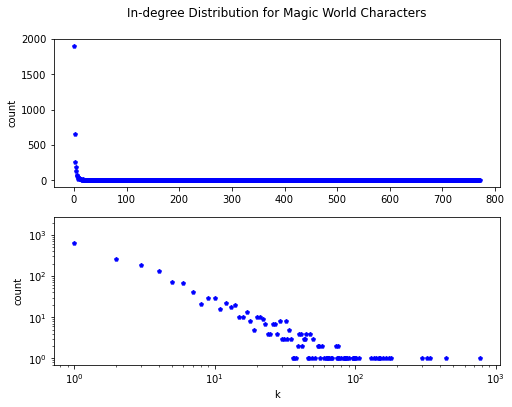

The maximum degree is 192, while the minimum degree is 0


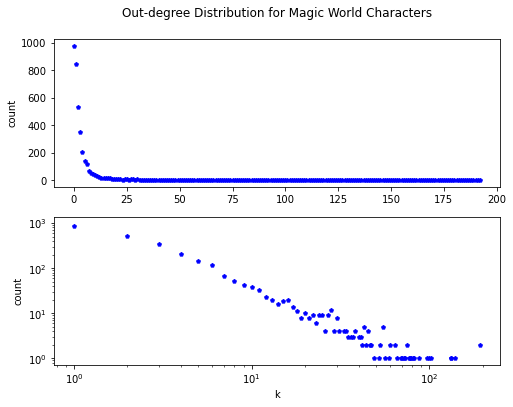

In [123]:
# degree distribution
in_degrees = [d for n,d in G.in_degree()]
out_degrees = [d for n,d in G.out_degree()]


def plot_degree_distribution(degrees,title):
    dmax = max(degrees)
    dmin = min(degrees)
    print('The maximum degree is {}, while the minimum degree is {}'.format(dmax, dmin))

    v = np.arange(dmin,dmax+2) # for the reason why here is '+2', please refer the 2.2 in part 1
    count,hist = np.histogram(degrees,bins=v) 
    hist = hist[0:-1] # del the last element
    
    plt.figure(figsize=(8,6))

    ax1 = plt.subplot(211)
    ax1.plot(hist,count,'p',color = 'blue',markersize=4)
    ax1.set_ylabel('count')

    ax2 = plt.subplot(212)
    ax2.loglog(hist,count,'p',color = 'blue',markersize=4)
    ax2.set_ylabel('count')
    ax2.set_xlabel('k')

    plt.title(title,pad = 200.0)
    plt.show()
    
# print('In degree\tmax:{}\tmin:{}'.format(max(in_degrees),min(in_degrees)))
# print('Out degree\tmax:{}\tmin:{}'.format(max(out_degrees),min(out_degrees)))
# print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_degrees if i >100])))
plot_degree_distribution(in_degrees,'In-degree Distribution for Magic World Characters')
plot_degree_distribution(out_degrees,'Out-degree Distribution for Magic World Characters')

In [129]:
# who has the most in-degree and out-degree
in_degree_sorted = sorted(dict(G.in_degree()).items(),key = lambda k :k[1],reverse=True)
print('The top 5 characters has the most in degrees:')
print(in_degree_sorted[0:5])
out_degree_sorted = sorted(dict(G.out_degree()).items(),key = lambda k :k[1],reverse=True)
print('The top 5 characters has the most out degrees:')
print(out_degree_sorted[0:5])

The top 5 characters has the most in degrees:
[('Harry_Potter', 771), ('Tom_Riddle', 446), ('Ronald_Weasley', 339), ('Hermione_Granger', 326), ('Albus_Dumbledore', 299)]
The top 5 characters has the most out degrees:
[('Albus_Dumbledore', 192), ('Harry_Potter', 192), ('Ronald_Weasley', 139), ('Tom_Riddle', 133), ('Hermione_Granger', 132)]


It could be observed that the Harry Potter network follows the power law in degree distribution. And we also have some similar finding like the Marvel/DC one, as the in-degree contains larger hubs with in-degree around 800, while the maximum out-degree is 192. These hubs are the main characters in Harry Potter stories like the protagonist group (Harry, Ron and Hermione), the boss of evils in this story:Tom Riddle(The Voldemort) and the headmaster of Hogwarts(Albus Dumbledore). It is also very interesting that the top 5 characters in both in and out degree are the same, which might indicates that the story of Harry Potter is more centralized in main characters compared with Marvel/DC.

# 3. Tools, theory and analysis. 
<!--
* Talk about how you've worked with text, including regular expressions, unicode, etc.
* Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
* How did you use the tools to understand your dataset?
-->

In this section, we are going to discuss the following interesting questions. We will propose the question, give the tools/theory we use and analysis the results. 
1. The connection between magic universe and muggle universe
1. 麻瓜世界与魔法世界的联系。
哈利波特的故事里除了无比强大的巫师们，还有不懂魔法的麻瓜们。对于大多数麻瓜们来说，他们是不知道有魔法世界的存在的，但是麻瓜和魔法世界又有着不可分割的关系。我们想知道：麻瓜世界和魔法世界的是如何连接的？是否有一些关键的结点？两个世界的大小，属性如何？是否有类似于six degree of separation的定律存在于魔法、麻瓜世界 已经两个世界中？ 

2. 四个学院的特征属性。
霍格沃兹有四个学院，在新生入学时，分院帽会将新生分到四个学院中的一个。根据JK罗琳对魔法世界的设定，分院帽会按照学生的特质进行分院——也就是说，每个学院应有自己特有的一些特征。比如，广泛认为，格兰芬多热情勇敢果决。我们想知道通过对fandom页面的文本分析+书的文本分析，来提取每个学院的关键词，得到其属性。

3. 哈利波特世界中人物的情感分析。
作为一个儿童读物，哈利波特中的人物具有鲜明的性格特点和感情倾向，我们很好奇，哪些人物更积极、开心；而哪些人物更加的阴郁、低落？同时我们也相对四个学院的社区进行这样的检测。

4. 利用文本信息的社区检测。
在社区检测方法中，权重值一直被我们所忽略。事实上，在人物A和B，C均认识的情况下，他们之间的关系紧密的强弱并不相同。我们利用文本信息，设计两个节点之间边的权重，再进行社区检测算法。我们将此算法应用在霍格沃兹学院内，讲通过算法产生的分隔与分院帽的结果进行对比，分析之间的不同并探索how smart the sorting hat is.

5. 预测分院结果。
输入一段文字描述，你将会被分到哪一个学院呢？我们希望可以将之前在网络中学习到知识与ML相结合，让哈迷们体验一下自己与哪个学院的特质更相近。

## 3.1 The connection between magic universe and muggle universe

In Harry Potter's world, apart from the powerful wizards, there are also Muggles who don't know about Magic. For most of Muggles, they don't even know that there is a magical world in out there, but Muggles and the magical world have an inseparable relationship. We want to know: how are the Muggle world and the wizarding world connected? Are there some key nodes to connect this two world? What are the sizes and properties of the two worlds? Is there a something similar to the six degree of separation in the Magic and Muggle worlds?

The above questions are what we eager to know!

In [1]:
# import necessary library for 3.1
import json
import networkx as nx
import requests
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
from community import community_louvain

### 3.1.1 The sub-network of muggles and wizards

In this section, we bulid the sub-network from the big whole network for muggles and wizards. Firstly, we get the character list for both muggles and wizards, then extract the subnetwork, finally we visualize the subnetworks. 

**Step 1**: get the character list for muggles and wizards. We get the list from Fandom category via Fandom API: [Muggles](https://harrypotter.fandom.com/wiki/Category:Muggles); [Wizards](https://harrypotter.fandom.com/wiki/Category:Wizards).

In [3]:
# read in the whole network
nodes_edges_json_file = './data/nodes_egdes_new.json'
with open(nodes_edges_json_file,'r') as f:
    node_edges = json.load(f)

# bulid the network from data 
G = nx.DiGraph()

# add nodes    
G.add_nodes_from(node_edges.keys())

# add links
for each in node_edges:
    for link in node_edges[each]:
        G.add_edge(each,link)
        
G = G.to_undirected()

print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

number of nodes in network:3705
number of links in network:11942


In [4]:
# get the list of muggles and wizards
house_cate_url = 'https://harrypotter.fandom.com/api/v1/Articles/List?expand=1&category=Muggles&namespaces=0&limit=1000'
r = requests.get(house_cate_url)
response = r.json()
a = 0
muggles = []
for item in response['items']:
    a += 1
    cha_name = str(item['title'].encode(encoding='utf-8'))[2:-1]
    if a != 1:
        muggles.append(cha_name.replace(' ','_'))
print('number of muggles:{}'.format(len(muggles)))

house_cate_url = 'https://harrypotter.fandom.com/api/v1/Articles/List?expand=1&category=Wizards&namespaces=0&limit=10000'
r = requests.get(house_cate_url)
response = r.json()
a = 0
wizards = []
for item in response['items']:
    a += 1
    cha_name = str(item['title'].encode(encoding='utf-8'))[2:-1]
    if a != 1:
        wizards.append(cha_name.replace(' ','_'))
print('number of wizards:{}'.format(len(wizards)))

number of muggles:407
number of wizards:2704


**Step 2**: Extract the subnetwork from the whole network.

In [5]:
both_list = [w for w in muggles if w in wizards]
print('There are {} characters in both muggles and wizards list'.format(len(both_list)))

There are 0 characters in both muggles and wizards list


In [8]:
muggle_wizard_network = []
muggle_wizard_network.extend(muggles)
muggle_wizard_network.extend(wizards)

In [13]:
G_muggles = G.subgraph(muggles)
print('Muggle network - number of nodes: {}\t number of links: {}'.format(len(G_muggles.nodes()),len(G_muggles.edges())))

G_wizards = G.subgraph(wizards)
print('Wizards network - number of nodes: {}\t number of links: {}'.format(len(G_wizards.nodes()),len(G_wizards.edges())))

G_mw = G.subgraph(muggle_wizard_network)
print('Muggle and Wizards network - number of nodes: {}\t number of links: {}'.format(len(G_mw.nodes()),len(G_mw.edges())))

Muggle network - number of nodes: 399	 number of links: 256
Wizards network - number of nodes: 2501	 number of links: 6416
Muggle and Wizards network - number of nodes: 2900	 number of links: 7194


**Step 3**: Visualize this three network. For Wizards and Muggles network, we also need to add node attribution to the network becore visualze them.

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 106.66it/s]


BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.08  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


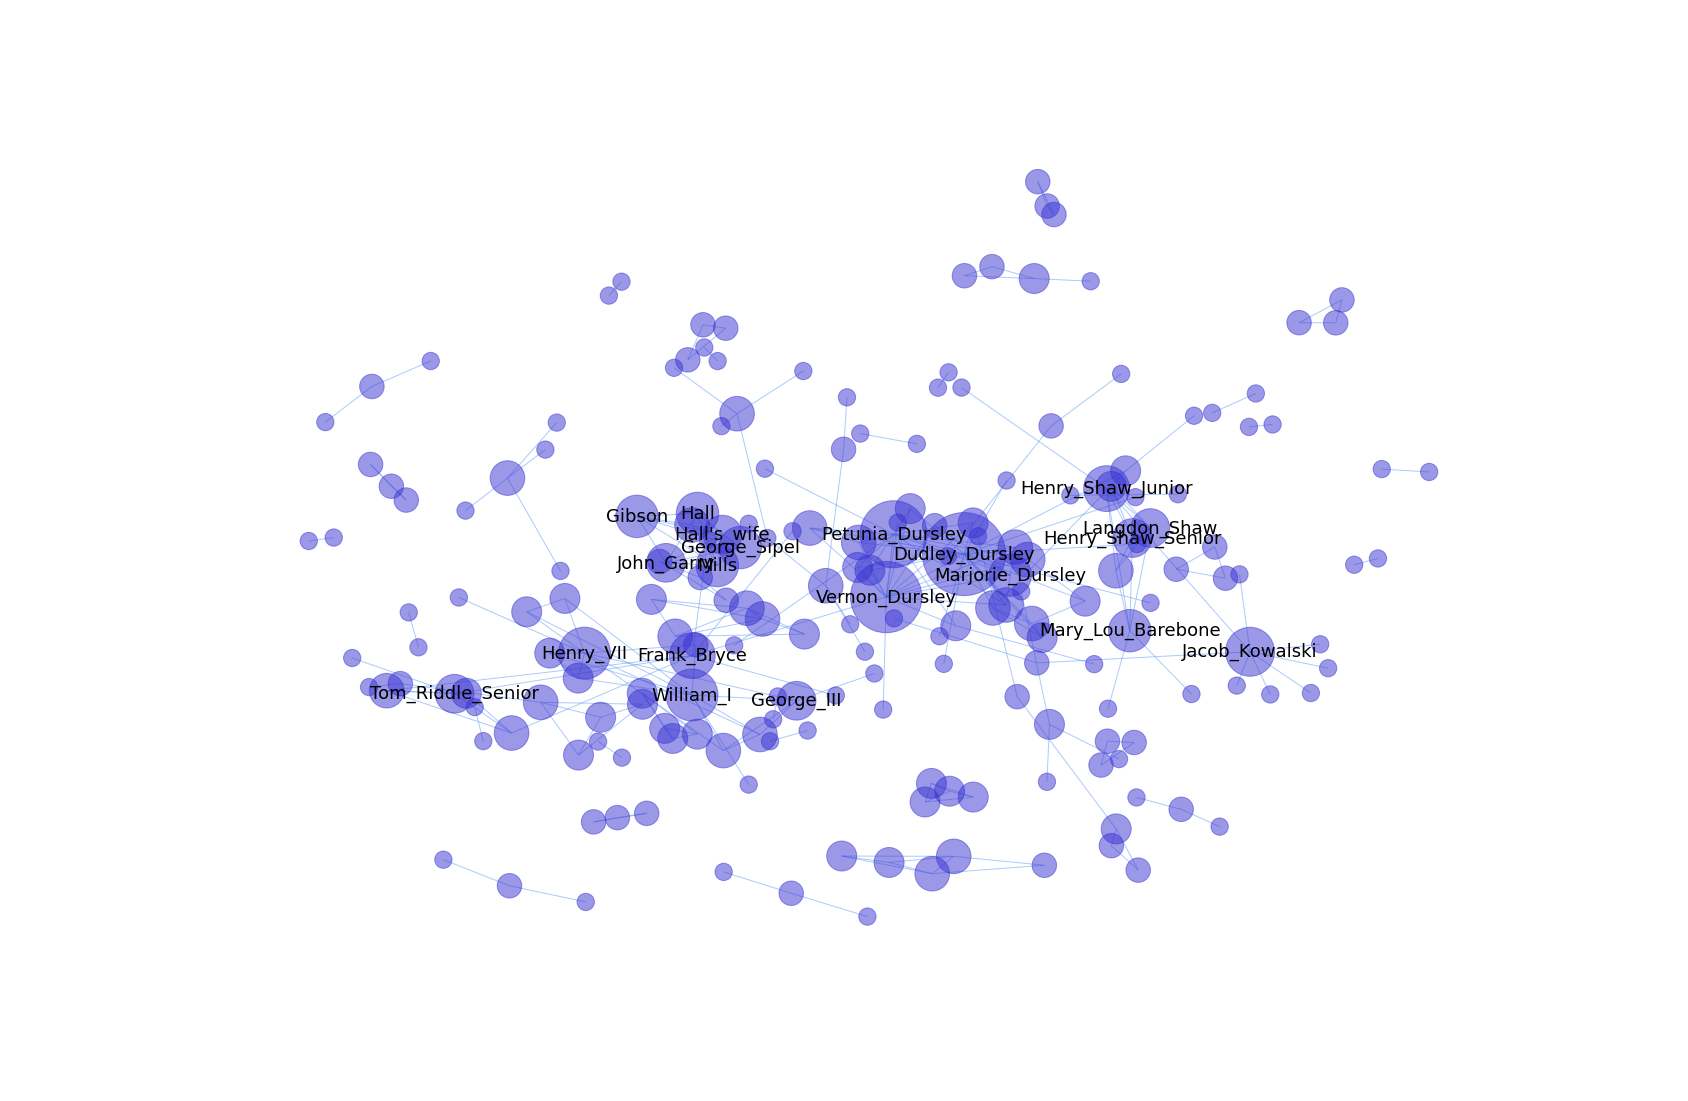

In [15]:
# get the dict of degree in G undirected 
d = dict(G_muggles.degree)

# get the top 20 degree character
d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

top_20_cha = list(d_sorted.keys())[0:20]

plt.figure(figsize=(30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=5, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_muggles, pos=None, iterations=10)
nx.draw_networkx(G_muggles, positions,nodelist=d.keys(), node_size=[v * 300 for v in d.values()], node_color = '#3833D1',alpha = 0.5,\
                    edge_color ='#5C98F7',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_muggles,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()

【可视化描述】
【建议：如果要把可视化放网站上，就需要加以解释。如果要放的话放那个two universes可能会好一点(不过不管放什么 都需要加解释 find something interesting from the plot and describe what we got)】

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.63it/s]


BarnesHut Approximation  took  0.13  seconds
Repulsion forces  took  1.14  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


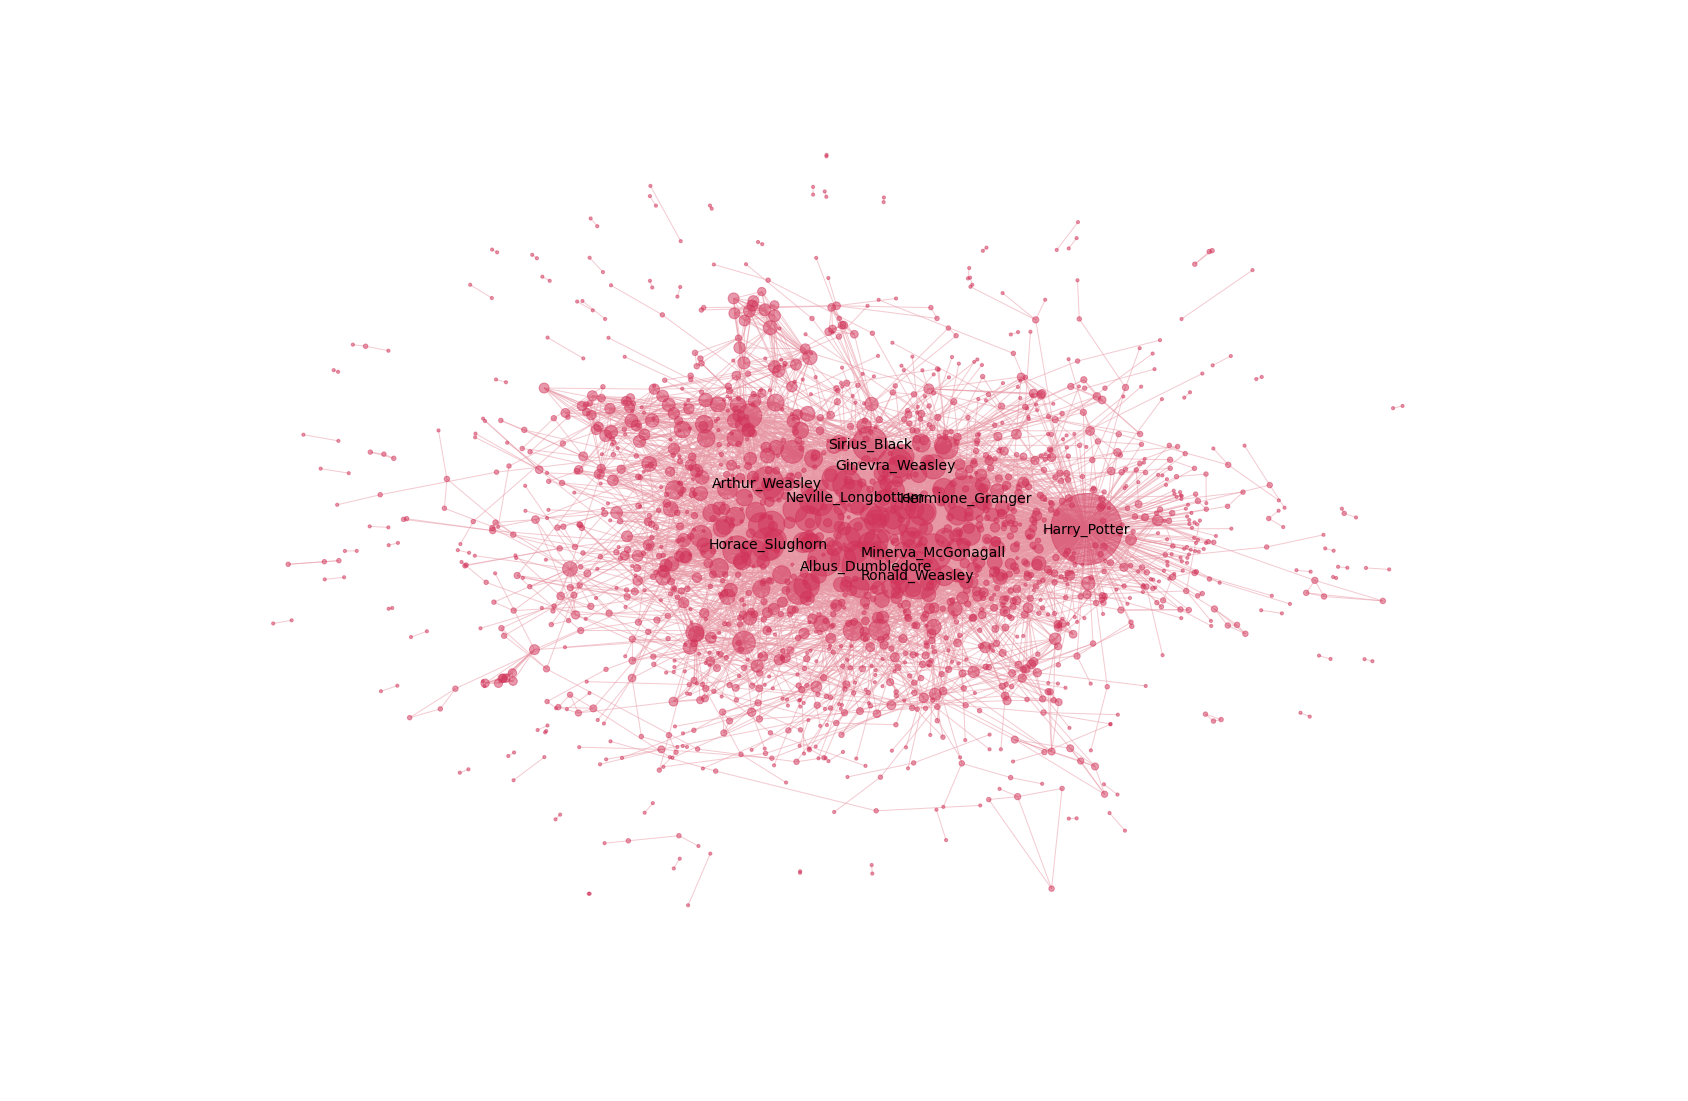

In [18]:
# get the dict of degree in G undirected 
d = dict(G_wizards.degree)

# get the top 20 degree character
d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

top_20_cha = list(d_sorted.keys())[0:10]

plt.figure(figsize=(30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=0.1, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_wizards, pos=None, iterations=10)
nx.draw_networkx(G_wizards, positions,nodelist=d.keys(), node_size=[v * 10 for v in d.values()], node_color = '#D13359',alpha = 0.5,\
                    edge_color ='#E797A4',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_wizards,positions,labels,font_size=14,font_color='k')
plt.axis('off')
plt.show()

In [19]:
# get the attribute dist for adding the attibute information into the Graph
mw_attr = {}

for node_name in G_mw.nodes():
    mw = 'Muggle'
    if node_name in wizards:
        mw= 'Wizards'
        
    mw_attr[node_name] = mw
    
# add the attribute to the network
nx.set_node_attributes(G_mw,mw_attr,'mw_type')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.67it/s]


BarnesHut Approximation  took  0.17  seconds
Repulsion forces  took  1.54  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


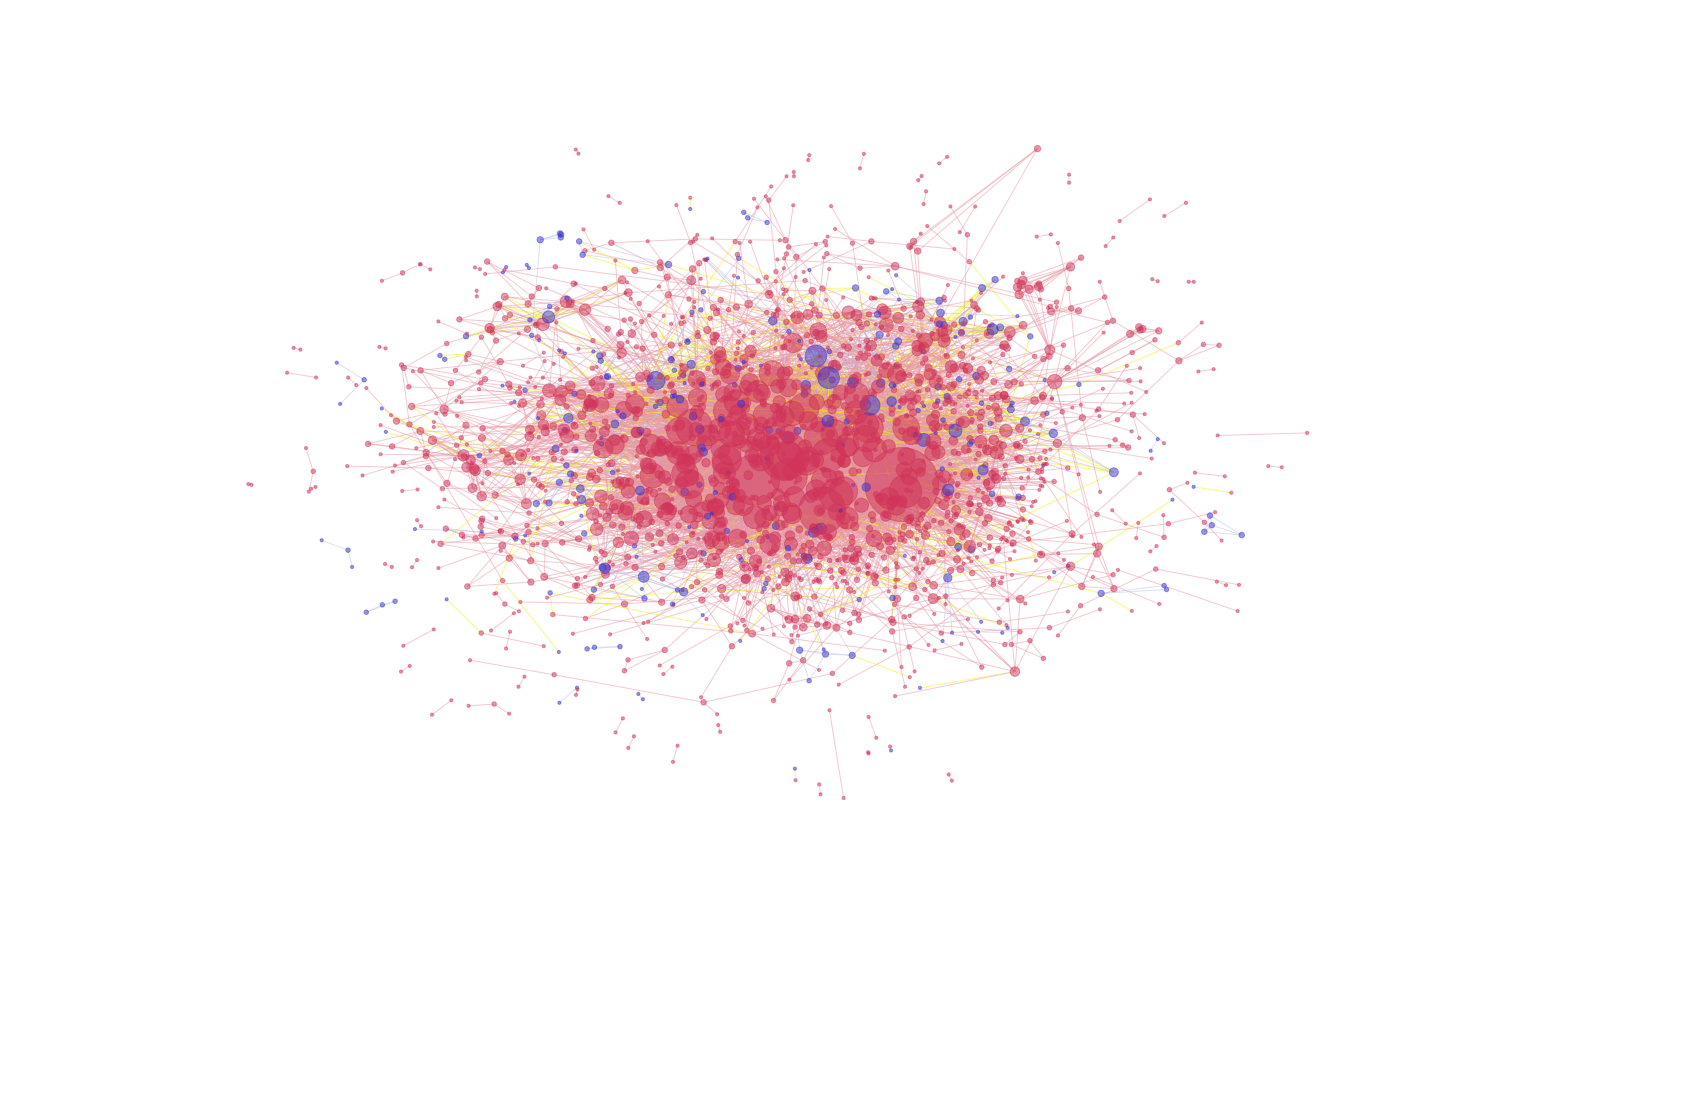

In [22]:
# visualization

# get the dict of degree in G undirected 
d = dict(G_mw.degree)

# get the top 20 degree character
d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

top_20_cha = list(d_sorted.keys())[0:20]

# represent for Muggles and Wizards
colors = ['#3833D1','#D13359']

# color map for nodes
color_map_nodes = []
i = 0
for node in list(G_mw.nodes()):
    if node in muggles :
        i+=1
        color_map_nodes.append(colors[0])
    else:
        color_map_nodes.append(colors[1])
# print(i)
        
colors_e = ['#BAC5EC','#E797A4','#F0F00C']
color_map_edges = []
cnt_cross = 0
for edge in list(G_mw.edges()):
    node_1, node_2 = edge[0],edge[1]
#     print(node_1, node_2)
    if node_1 in muggles and node_2 in muggles:
#         print(0)
        color_map_edges.append(colors_e[0])
    elif node_1 in wizards and node_2 in wizards:
#         print(1)
        color_map_edges.append(colors_e[1])
    else:
        color_map_edges.append(colors_e[2])
        cnt_cross+=1

plt.figure(figsize=(30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=50, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_mw, pos=None, iterations=10)
nx.draw_networkx(G_mw, positions,nodelist=d.keys(), node_size=[v * 10 for v in d.values()], node_color = color_map_nodes,alpha = 0.5,\
                    edge_color =color_map_edges,with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
# nx.draw_networkx_labels(G_mw,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()

We could see that the Muggles network is really small compared with the Wizards. And they are not fully connected. The biggest clustering here is the Dursley Family, including Petunia Dursley(Harry Potter's Anut), Vernon Dursley(Harry's uncle), Dudley Dusley(Harry's cousin) and Majorie Dursley(Vernon Dursley's elder sister).


In Wizards world, there's a huge node which is the Harry Potter, the other important nodes here are the main character of Harry Potter Book and Movies. We could also notice that the Wizard network is very dense and the majority of them are conneted to others while some of the nodes are isolated.

In the network contains both wizards and muggles:  
1. Muggles nodes are connected with Wizards world, rather than connected with other muggles. That's why with this Force-directed graph drawing, it is very hard to seperate this two universes.  
2. Red links represent the links between wizards, blue links represent the links between muggles, and the yellow links represent the links between muggle and wizard. It could be observed that the number of yellow links are not small. 

These two observesation reflects the fact that in Harry Potter world, the wizards are the main characters and the focus of the story. That's why the biggest nodes in Muggles world are highly related to Harry Potter. The Muggles world might not be representative enough to be regard as the *normal people* world in real life, as there's definetly more *normal people* out there but not described in Harry Potter.

### 3.1.2 The connection between Muggles and Wizards world

In this section, we are interested in how this two universe connect with each other. Firstly, we count the number of links between Muggles and Wizards, then we discover the muggles who know the most wizards, and the wizards who know the most muggles.

**Step 1:** the links between the two universes.

In [41]:
cnt_cross = 0
for edge in list(G_mw.edges()):
    node_1, node_2 = edge[0],edge[1]
    if node_1 in muggles and node_2 in muggles:
        pass
    elif node_1 in wizards and node_2 in wizards:
        pass
    else:
        cnt_cross+=1
print('There are {} links acrosee muggles and wizards'.format(cnt_cross))

There are 522 links acrosee muggles and wizards


We could see that there are 522 links across muggles and wizards world. This number is even more than the number of muggles, which means that for each muggle, he/she knows more than 1 wizard on average. This fact is apparently not the truth! As described in the Harry Potter book, most of the muggles do not even know the magic world exists. So here we could infer that the muggles in the Harry Potter book must be a very special group compared with the *normal* muggles. This inference is reasonable as the story is based on the magic world so it is not surprising that the muggles here know at least one wizard.

**Step 2:** Find the Muggles who know the most wizards.

In [26]:
muggle_link_wizard={}
for muggle in muggles:
    if muggle in G_mw.nodes():
        edges = G_mw.edges(muggle)
        l = []
        for e in edges:
            node2 = e[1]
            if node2 in wizards:
                  l.append(node2)
        muggle_link_wizard[muggle] = l
        
muggle_link_wizard_sorted = sorted(muggle_link_wizard.items(),key = lambda k:len(k[1]),reverse=True)
for i in range(10):
    name= muggle_link_wizard_sorted[i][0]
    num = len(muggle_link_wizard_sorted[i][1])
    print('{}\t{}\t{}'.format(i+1,name,num))

1	Vernon_Dursley	30
2	Jacob_Kowalski	25
3	Dudley_Dursley	24
4	Petunia_Dursley	24
5	James_Steward	14
6	William_Shakespeare	13
7	Hermione_Granger's_mother	12
8	Tom_Riddle_Senior	12
9	Frank_Bryce	10
10	Hermione_Granger's_father	9


Dursley Family and Granger Family are the muggles who know the most wizards! Vernon Dursley and Petunia Dursley is Harry Potter's aunt and uncle, and Dudley is their son. This finding is not surprising at all, as they are the family of the two main characters: Harry Potter and Hermione Granger. For some characters also appears in this list: 
- Jacob Kowalski is a muggle friend of Newt Scamander, who is the main character of *Fantastic Beasts and Where to Find Them*
- James Steward helped to found a wizarding school, as well as to have been a headmaster of a wizarding school though he himself is a muggle. He appears in *PotterMore*.
- William Shakespeare, well he also appears in the Harry Potter story! Seems J.K. Rowling likes Shakespeare's work a lot.

**Step 3**: Find the wizards who know the most muggles.

In [27]:
wizard_link_muggle={}
for wizard in wizards:
    if wizard in G_mw.nodes():
        edges = G_mw.edges(wizard)
        l = []
        for e in edges:
            node2 = e[1]
            if node2 in muggles:
                  l.append(node2)
        wizard_link_muggle[wizard] = l
wizard_link_muggle_sorted = sorted(wizard_link_muggle.items(),key = lambda k:len(k[1]),reverse=True)
for i in range(10):
    name= wizard_link_muggle_sorted[i][0]
    num = len(wizard_link_muggle_sorted[i][1])
    print('{}\t{}\t{}'.format(i+1,name,num))

1	Harry_Potter	34
2	Albus_Dumbledore	23
3	Hermione_Granger	15
4	Ronald_Weasley	14
5	Lily_J._Potter	12
6	Newton_Scamander	12
7	James_Potter_I	10
8	Sirius_Black	9
9	Minerva_McGonagall	9
10	Credence_Barebone	8


It seems that the characters that appear in this list are the main characters in the Harry Potter world. We guess this might because they are the main characters of this book/film, so the muggle they knew was mentioned. There's a great chance that other characters also know some muggles, however, as they do not describe in detail, so the relationship is missing here.

### 3.1.3 *Six* degrees of Seperation in Muggles and Wizards world

A very famous law in network science is the Six degrees of Seperation. It means that all people on average are six, or fewer, social connections away from each other. We want to verifiy this in both muggle and wizard world and to see whether they have the similar laws, such as *X* degrees of Seperation. 

The six degree here means the average shorted path in the network is around 6. So we calculate the average and also the maximum shortest path in networks.

**Step 1:** In muggle world.

In [28]:
print('In muggle world:')
Gcc = sorted(nx.connected_components(G_muggles), key=len, reverse=True)
G0 = G_muggles.subgraph(Gcc[0])

avg_shortest_path = nx.average_shortest_path_length(G0)

print('average shortest path:{}'.format(avg_shortest_path))

paths_len = nx.all_pairs_shortest_path_length(G0)

max_distance = 0
for node in paths_len:
    max_ = max(node[1].values())
#     print(max_)
    if max_ > max_distance:
        max_distance = max_
#     print(max_distance)
print('max shortest path:{}'.format(max_distance))

In muggle world:
average shortest path:2.647560975609756
max shortest path:6


**Step 2:** In wizard world.

In [29]:
print('In wizard world:')
Gcc = sorted(nx.connected_components(G_wizards), key=len, reverse=True)
G0 = G_wizards.subgraph(Gcc[0])

avg_shortest_path = nx.average_shortest_path_length(G0)

print('average shortest path:{}'.format(avg_shortest_path))

paths_len = nx.all_pairs_shortest_path_length(G0)

max_distance = 0
for node in paths_len:
    max_ = max(node[1].values())
#     print(max_)
    if max_ > max_distance:
        max_distance = max_
#     print(max_distance)
print('max shortest path:{}'.format(max_distance))

In wizard world:
average shortest path:3.6245832410820102
max shortest path:12


**Step 3:** In the world contains both wizard and the muggles.

In [30]:
print('In the world contains both wizard and the muggles:')
Gcc = sorted(nx.connected_components(G_mw), key=len, reverse=True)
G0 = G_mw.subgraph(Gcc[0])

avg_shortest_path = nx.average_shortest_path_length(G0)

print('average shortest path:{}'.format(avg_shortest_path))

paths_len = nx.all_pairs_shortest_path_length(G0)

max_distance = 0
for node in paths_len:
    max_ = max(node[1].values())
    if max_ > max_distance:
        max_distance = max_
print('max shortest path:{}'.format(max_distance))

In the world contains both wizard and the muggles:
average shortest path:3.6982306704468613
max shortest path:12


We could see that the average shortest path and maximum shortest path is much smaller in the muggle universe, which does not match out expectation. However, this result makes sense considering we are using the Harry Potter stories as the materials. 

It could be observed that the average shortest path of the wizard universe is around 3.6, which is small compared with the real world, where the average shortest path is 6 according to Six Degrees of Separation. 

What is interesting here is that the average shortest path increased when we add these two universes together. This fact indicates that the two universes are somehow independent of each other. 

**Step 4:** The average shortest path between wizards and muggles. 
We are interested in: if there's a wizard and a muggle, what is the most likely shortest path for them? Image that we have a magic world in real life, how many people between you and someone knows magic?


In [65]:
cnt = 0
sum_path = 0
m_cnt, w_cnt = 0,0
for node in paths_len:
    if node[0] in muggles:
        m_cnt+=1
        edges = node[1]
        for node_2 in edges.keys():
            if node_2 in wizards:
                cnt+=1 
                sum_path+=edges[node_2]
    else:
        w_cnt+=1
        edges = node[1]
        for node_2 in edges.keys():
            if node_2 in muggles:
                cnt+=1 
                sum_path+=edges[node_2]
print('the average shortest path between muggles and wizards is:{}'.format(sum_path/cnt))

the average shortest path between muggles and wizards is:3.8544679089310274


The average shortest path between muggles and wizards is 3.85, which is definitely shorter than we expect, but it is reasonable as we explained before(with the Harry Potter stories as context). What worth noticing here is that 3.85 is larger than the average shortest path for all the sub-network above, which implies the connection between wizards and muggles is less closed compared with wizard-wizard and muggle-muggle.

**Step 5:** How the two irrelevant role connected with each other.

In [62]:
cha_1 = 'Miles_Bletchley' # the Slytherin Quidditch team - Keeper
cha_2 = 'Ignatia_Wildsmith' #Ignatia Wildsmith (1227—1320) was a witch and wizarding inventor, who was famously the creator of Floo Powder. 

print('The shorest path between {} and {} is: \n{}'.format(cha_1,cha_2,paths_dict[cha_1][cha_2]))

The shorest path between Miles_Bletchley and Ignatia_Wildsmith is: 
['Miles_Bletchley', 'Angelina_Johnson', 'Parvati_Patil', 'Robert_Hilliard', 'Ignatia_Wildsmith']


We here present an example. The two nodes that we are testing here is Miles Bletchley and  Ignatia Wildsmith. 

Miles Bletchley is the keeper of the Slytherin Quidditch team. Ignatia Wildsmith (1227—1320) was a witch and wizarding inventor, who was famously the creator of Floo Powder. They are from the different era, so that's see how could these two people connected!

**Miles Bletchley connects Angelina Johnson**: Bletchley played in Slytherin's match against Gryffindor this year. He was unable to block Gryffindor's only goal attempt during that match, from Angelina Johnson.

**Angelina Johnson connects Parvati Patil** They both are members of the Dumbledore's Army.

**Parvati Patil connects Robert Hilliard** Parvati Patil does not have typical traits of Gryffindor, pointing out by Ravenclaw prefect Robert Hilliard. (*prefect* here was a student who had been given extra authority and responsibilities by the Head of House and Headmaster)

**Robert Hilliard connects Ignatia Wildsmith** Both Robert Hilliard and Ignatia Wildsmith belong to Ravenclaw, and she was once mentioned by Robert Hilliard in speech.

## 3.2  The most representative words for each house in Hogwarts

Hogwarts has four houses. When freshmen are enrolled, the Sorting Hat will assign the freshmen into one of the four houses. According to J.K. Rowling's setting for the wizard world, the sorting hat will assign the students according to their characteristics. In other words, each house has its own unique characteristics. For example, it is widely believed that Gryffindor is passionate, brave, and decisive. We want to extract the keywords of each house through NLP analysis of fandom pages.

  
### 3.2.1 Get the Hogwarts subnetwork from Fandom    
We could get the sub-network of Hogwarts from Fandom [This page](https://harrypotter.fandom.com/wiki/Category:Individuals_by_Hogwarts_house).
By Fandom API, we could get the student list of each house. 

This step is explained more detailed in section 3.2.2.

### 3.2.2 Extract the representative words for each house
In this section, both **TF-TR** and **TF-IDF** are attempted.
<br>So just to simply summarize the important highlights for this section:
<br>(1)Modify the formula for calculating <b>TF</b> to reduce the influence of <b>TF</b>.
<br>(2)Remove the names of characters in the lists of words.
<br>(3)Take the adjective words.


>Step one: TRY <b>TF-IDF</b>

>**TF-IDF:**<br>
**TF** stands for <b>Term frequency</b>, which represents for 
<b><center>The weight of a term that occurs in a document is simply proportional to the term frequency.</center></b>
From six weighting scheme, the double normalization 0.5 is chosen by us because the augmented frequency helps prevent the bias towards longer documents.
$$tf(t,d) = 0.5+0.5\times \frac{f_{t,d}}{max\{f_{t',d},t'\in d\}}$$  

>**IDF** is short for **Inverse document frequency**, which meansthat 
<b><center>The specificity of a term can be quantified as an inverse function of the number of documents in which it occurs.use inverse document frequency smooth. </b></center>
From five weighting scheme, the inverse document frequency smooth is selected.With *log* in the formula,it would be smoother in the curve.Moreover, by adding one in denominator, the zero in denominator will be avoided.
$$idf(t,D) = \log(\frac{N}{ 1+ n_t}) +1$$  

However,in our case, we could illustrate from the results that TF-IDF is not appropriate. Due to the complicated story of Harry Potter, a lot of the names of the charactors and keywords appearred in each house. That is to say, the <b>IDF</b> term hardly plays its role in <b>TF-IDF</b>.Hence, we tried <b>TF-TR</b> as follows.

>Step two:Try <b>TF-TR</b>

In [29]:
# import the library for this part
import json
from tqdm import tqdm
import os
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

>Hence, we prepared our data for TF-TR. <br>Firstly, we got the data of character list for each house in Hogwarts. The json file we read here is previously generated from the Famdom category page: [Individuals_by_house]( https://harrypotter.fandom.com/wiki/Category:Individuals_by_house). Noticed that we need to replace the blank with underscore here, as the text file from each Fandom page is named with underscore.

In [30]:
#load the json file
# the json file in generated from the catagory in Famdom: https://harrypotter.fandom.com/wiki/Category:Individuals_by_house
parent_folder = './data/' # '/Users/zhengqing/desktop/'
four_houses = parent_folder +'hogwarts_house.json'
with open(four_houses,'r') as f:
    four_houses_dict = json.load(f)

# get the list fro each house
for key in four_houses_dict.keys():    
    new_items = []
    for a in four_houses_dict[key]:
        new_item = a.replace(" ", "_")
        new_items.append(new_item)
    four_houses_dict[key] = new_items

>In this case,we got the list for all character in Harry Potter Network. 
However, we removed all names of characters in the following text analysis, as the names do not contribute to the personality analysis of each house. Both the first name and the last name will be collected in this list because the full name is usually splitted. 

In [31]:
# get a list of character name for later removing
four_houses = parent_folder +'nodes_egdes_new.json'
with open(four_houses,'r') as f:
    node_edges = json.load(f)

character_names_set = []
for node in node_edges.keys(): 
    character_names_set.extend(node.lower().split('_'))
character_names_set.extend(['ginny']) # some nicknames of the characters
character_names_set = set(character_names_set)
print('The number of character names should be removed:{}'.format(len(character_names_set)))

The number of character names should be removed:4541


>After that, we define a function to generate the word list from raw text. The followings are the specific steps:
1. Tokenize from the string text and get the raw word list
2. Lower all the words.
3. Filter the words with part of speech. Here, as we care about the personality analysis for students in each house, we only collect the adjective words
4. Remove all the stopwords in English.
5. Remove all the names in Harry Potter character list.

In [32]:
# define the funtion to generate the raw word text(with punctuation marks) from a raw_text
from nltk.corpus import stopwords
from nltk import pos_tag
stop_words = set(stopwords.words('english'))

def get_word_list(raw_text):
    token = word_tokenize(raw_text)
    tokenize_nopunc= [w for w in token if w.isalpha()]#remove the punctuation
    tokenize_nopunc_lower = [w.lower() for w in tokenize_nopunc]# lower the words
    tokenize_nopunc_lower = [w for (w,pos) in pos_tag(tokenize_nopunc_lower) if pos == 'JJ']# take the adjectives words only
    tokenize_nopunc_lower_nostop = [w for w in tokenize_nopunc_lower if  w not in stop_words]# remove all the stopwords in Engli
    # remove the character name  
    tokenize_nopunc_lower_nostop = [w for w in tokenize_nopunc_lower if w not in character_names_set]
    return tokenize_nopunc_lower_nostop

>Now, it's time to get the TF list for each house. 
<br>We create a list called word_bank to store all words, which has been pre-processed before. 
<br>Also, we check if the nodes exist in our node cleaned file, if not, we just skip and continue.
<br>Hence, we got the lists of words in each house.

In [33]:
data_folder = parent_folder + '/cha_fandom_page_text/'
tf_lists_all = {}
#get the tf list for each community

for community in four_houses_dict:
    word_bank = [] 
    # get the nodes in each community
    node_list = four_houses_dict[community]
    # word_bank: tore all word (have already removed punctuation, lowered the words, and done the stemming)
    for node_name in node_list:       
        file_path = os.path.join(data_folder,node_name+'.txt') 
    #check if the file exist, if not, just skip and continue
        try:
            with open(file_path,'r',encoding='utf-8') as f:
                raw_text = f.read()               
            processed_words = get_word_list(raw_text)
            word_bank.extend(processed_words)
            #remove the unnecessary/unimportant word
#             token_lst = [word for word in word_bank if word not in remove]
        except:
#             print(node_name)
            pass
    print('the number of words in community{}:{}'.format(community,len(word_bank)))
    tf_raw = nltk.FreqDist(word_bank)
    tf_lists_all[community] = tf_raw


# store the tf_infor into json
# json_path = '/Users/zhengqing/desktop/hp/four_houses.json'
json_path = parent_folder+'/houses_tf_list.json'
with open(json_path,'w') as f:
    json.dump(tf_lists_all, f)

the number of words in communityGryffindors:22863
the number of words in communityHufflepuffs:5561
the number of words in communityRavenclaws:6178
the number of words in communitySlytherins:13614
the number of words in communityUnknown House:6274


>Now, we get the <b>TR</b> list and <b>TF-TR</b> list for each house.  
We modify the <b>TR</b>(Term Radio) Formula in Sune's lecture notes in Week 7. 
<br>Firstly, the <b>TF</b> is used for two universes in lecture notes, but here we have 5 communities. 
<br>Therefore, the <b>TF</b> calculation is improved by the following Formula: 
$$TF = \frac{TF_{self}}{TF_{others} + c}$$
where $TF_{others} = \sum_{i\neq self} TF_i $.
And the <b>TF-TR</b> formula is improved as follows:
$$TF-TR = (TF)^{0.5}\times(TR)$$
By the exponent 0.5, the influence by <b>TF</b> would be decreased. <br>We take this step because we noticed that for some words, though they have a lower <b>TR</b> but the <b>TF</b> is too high, which leads to a high <b>TF-TR</b> score. 
<br>What's more, we are more concerned about the differences between each house here, so we want to reduce the influence of <b>TF</b>.

In [34]:
# get the tr_list for each house
c = 1
tf_tr_list = {}
for house in tf_lists_all.keys():
    tf_tr_list[house] = {}
    other_house_list = [h for h in tf_lists_all.keys() if h is not house]
    #print('self house:{}\tother houses:{}\n'.format(house,other_house_list))
    
    for word in tf_lists_all[house].keys():
        tf_self = tf_lists_all[house][word]
        tf_other = []
        for other_house_each in other_house_list:
            if word in tf_lists_all[other_house_each].keys():
                tf_other.append(tf_lists_all[other_house_each][word])
            else:
                tf_other.append(0)
        
        tf_other_mean = np.sum(tf_other)
        w = tf_self/(tf_other_mean + c)
        tf_tr_ = w*(tf_self**(1/2))
        #print('{}\t\t{}\t{}\t{}\t{}'.format(word,tf_self,tf_other_mean,w,tf_tr_))
        tf_tr_list[house][word] = tf_tr_


In [35]:
for community in tf_tr_list:
    tf_tr = tf_tr_list[community]
    tf_tr_sorted = sorted(tf_tr.items(), key=lambda kv: kv[1],reverse=True)
    print('In community {}, the top 10 terms according to TF-TR are:'.format(community))
    for i,each in enumerate(list(tf_tr_sorted)[:10]):
        print('({}){}:{:.2f}, '.format(i+1,each[0],each[1]),end='')
    print('\n')
#     print('In community {}, the top 10 terms according to TF-TR are:{}\n'.format(community,list(tf_tr_sorted)[:20]))

In community Gryffindors, the top 10 terms according to TF-TR are:
(1)overdue:82.82, (2)quality:27.44, (3)text:27.44, (4)irresponsible:22.63, (5)good:22.49, (6)other:21.36, (7)serious:20.30, (8)several:19.16, (9)ecstatic:18.52, (10)wormtail:18.52, 

In community Hufflepuffs, the top 10 terms according to TF-TR are:
(1)variable:22.63, (2)newt:22.09, (3)ernie:10.67, (4)religious:8.00, (5)macusa:8.00, (6)metamorphic:8.00, (7)flowering:5.20, (8)bibble:5.20, (9)forgetfulness:5.20, (10)spiky:5.20, 

In community Ravenclaws, the top 10 terms according to TF-TR are:
(1)verdimillious:18.52, (2)dirigible:14.70, (3)warwick:11.18, (4)fraudulent:8.00, (5)nanny:8.00, (6)leek:8.00, (7)lovely:5.59, (8)portree:5.59, (9)jewish:5.59, (10)honorary:5.59, 

In community Slytherins, the top 10 terms according to TF-TR are:
(1)tree:19.52, (2)respectable:17.46, (3)nazi:14.70, (4)bloodline:14.70, (5)melbourne:14.70, (6)sacred:11.68, (7)persian:11.31, (8)immortal:11.31, (9)vain:11.18, (10)thuggish:11.18, 

In co

We can get some of the key attributes from the results(top 10),however,in order to better see the key personality descriptions of each house, we use WordCloud to visualize the result as follows.

### 3.2.3 WordCloud and Discussion
><br>Since WordCloud is only able to analyze text insteaf direct dictionary TF=TR analysis, a pseudo-text to represent the TF-TR result is generated by us firstly. 
<br> Firstly, a list is created to store the words.And we took the value from the dictionary to round it as int.
Then, we extend the int(we generated) into the list by multiply the specific word.
<br>For example, [w]*10 = [w,w,w,w,w,w,w,w,w,w,w].
<br>After that, the pseudo-text is visualized through the WordCould library. For each house, we use their color in the color diagram. The results are shown below.

In [48]:
#prepare for drawing
def tf_tr_to_string(tf_tr_dict):
    word_list = []
    for w in tf_tr_dict:
        tf_tr  = tf_tr_dict[w]
        times = int(round(tf_tr))
        word_list.extend([w]*times)
    string = ' '.join(word_list)
    return string

In [54]:
def draw_wordcloud(community_name,cm):
    tf_tr = tf_tr_list[community_name]
    commu_str = tf_tr_to_string(tf_tr)

    wordcloud = WordCloud(
        max_words= 200,
        background_color = 'white',
                          width=800,
                          height=600,
                          collocations=False,
                          colormap= cm
                         ).generate(commu_str)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('world could for community {}'.format(community_name))
    plt.show()

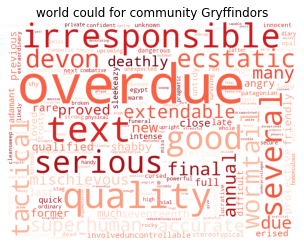

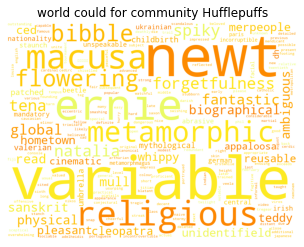

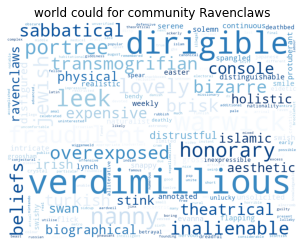

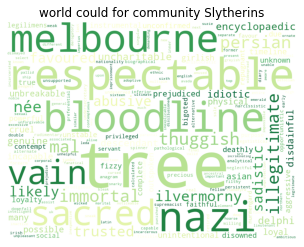

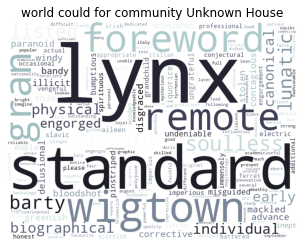

In [55]:
colormap = [ 'Reds','Wistia','Blues','YlGn','bone']
for i,community in enumerate(tf_tr_list):
    draw_wordcloud(community,colormap[i])

<br>We can get some key attributes from the wordcloud which make sense to us.
><br><b>Gryffindor</b> is known as the House of brave and daring. Its symbol is the lion with the colors red and gold.Its founder was Godric Gryffindor ang the element of Gryffindor is fire. To be more specific, students who belong to Gryffindor are usually very bold and chivalrous, but they can also be reckless and arrogant. 
<br>The attributes keywords for Gryffindor are illustrate as overdue, quality,irresponsible,good,serious,ecstatic,tactical,etc.The positive attributes such as good, quality correspond with
chivalry of Gryffindor while the negative words such as irresponsible,might meet with the characteristic of reckless or arrogant.
<br>Moreover, the main characters including Harry Potter, Ron Weasley, Hermione Granger, and Albus Dumbledore all belongs to Gryffindor.Hence,it is seen as the main house, into which almost every main character is Sorted, possibly to expand on their rivalry against Slytherin house, which is the house of Voldemort. It also means the importance of bravery in times of war, and the chivalry that gryffindor students have for loyalty to one another.So the keywords such as tactical make a lot of sense in this way.




><b>Hufflepuff</b> is described as the "House of Loyalty and Justice". The mascot is a badger - in yellow and black. The founders were Helga Hufflepuff, and the earth was their element. 
<br>Hufflepuff students are considered loyal, fair, hardworking and friendly. Nevertheless, they are slighted by others, and are seen as people who do not fit into the other three houses, or are seen as “weak” or “untalented”.  Famous members include Cedric Diggory, Nymphadora Tonks and Newton Scamander. "Hufflepuff" may be a way of observing how other misfits are treated unfairly in society, or it may be that these so-called "cranks" have deeper thoughts, with their own interests, skills, and talents.
<br>Some key words show people's contempt for this college, such as newt, metamorphic,forgetfulness.The key attributes such as religious correspond with the loyalty of the Hufflepuff students.

><b>Ravenclaws</b> is considered as the house of the wise. Their insignia, which was blue and bronze, was eagle. It was founded by Rowena Ravenclaw and the element of the house is air. 
<br>Ravenclaw's students are bright, intelligent and studious, while the key words such as honorary and lovely correspond with that.But they are regarded as "weird" and very highly competitive in exams. So key attributes such as fraudulent might be the subjective description from others. Famous members included Luna Lovegood, Felix Flitwick, and Cho Chang. The story of Ravenclaw's ghost, the Grey Lady, who helps Harry find the crown of Ravenclaw, may reflect themes of power, betrayal, jealousy and pride. In a member like Luna Lovegood, Ravenclaw might be interpreted to mean that there is knowledge in everything, even though knowledge may not exist at all, or seem unbelievable.


><br>Meanwhile, known for being combative and caring about pure blood, <b>Slytherins</b> College has key characteristics for its students as follows:respectable,nazi,bloodline,sacred,persian,immortal,vain,thuggish,etc, which can be explained as follows.
<br>Slytherin is also described as a house full of ambition and cunning. Their utensils are snakes while their colors green and silver. The founder was Salazar Slytherin, and water is regarded as their element. 
<br>The Slytherins were ambitious, power-hungry, and of course tend to be pure blood. 
It is considered the "worst house" , with the blackest wizards and witches. They were portrayed as the least popular of the four houses. Famous members include Tom Riddle (Voldemort), Draco Malfoy, and Severus Snape. In harry potter stories, they are seen as "dark houses", representing evil. 
<br>However, not every Slytherin is dark, which may represent that the concept of good and evil is not simple, especially with Professor Snape. It might be useful to say that even people who are assigned to houses like Slytherin -- or any other similar reality -- are not necessarily "bad".

><br>Lastly, for other people not belonging to the four houses but also within the Hogwards,regarded as <b>Unknown</b> , the top's character keywords can be summarized as: lynx,standard,gossipy,soulless,etc.

## 3.3 Sentiment anslysis for characters/houses in Harry Potter network

As one of the most famous contemporary novels, the book of Harry Potter is also the object of our study. The original novel is undoubtedly the most revealing source of information about the World of Harry Potter.
Therefore, we try to analyze the text of The Harry Potter novels. We hope to help us better understand the world of Harry Potter by discussing the characters in the novel.
In fact, the sentiment tendency of characters can be reflected by calculating the sentiment values of the characters through text mining, and the character similarity is reflected by the similarity between the character description and the dialogue text. Taking advantanges of those technology for the reason that we expect to explore the division criteria of sorting hat.

In [ ]:
!pip install snownlp
!pip install -U textblob
!python -m textblob.download_corpora
!pip install --upgrade gensim

### 3.3.1 preprocessing for text
Divide the book contents into different characters according to their names. Each character is given a text containing the text sentences that appear in the book.<br/>
(1) Pick out the name of characters from nodes and put it into a list after table conversion.<br/>
(2) Traversed the entire text set, followed the punctuation marks at the end of the sentence, and divided the text into a list in units of sentences.<br/>
(3) Loop the nested form to judge whether the character name appears in the sentence.Categorize the sentences that have appeared in the name of the person and save them in the TXT document with the name of the corresponding role.<br/>
(4) For the main characters, considering that in many cases only the first name and last name appear in the sentences, which mostly refer to the main characters,<br/>
So select the last name and first name of the main character to filter the text and override the previous content.<br/>

In [34]:
import numpy as np
import pandas as pd
import json
import re
import string
import nltk
from nltk.corpus import stopwords
import nltk.stem

(1) Pick out the name of characters from nodes and put it into a list after table conversion.

In [35]:
# function for standardize the name of txt
def file_rename(characters): 
    character_list = list(characters)
    char_list = []
    for character in character_list:
        char_list.append(character.lower().replace('_',' '))
    character_list = char_list
    return character_list

In [36]:
# read text from local
book = open('./data/book.txt').read()
# read and parse characters' json document from local
characters = open('./data/nodes_egdes_new.json').read()
characters = json.loads(str(characters))
characters = characters.keys()
character_list = file_rename(characters) # standardize the file name format

(2)Traversed the entire text set, followed the punctuation marks at the end of the sentence, and divided the text into a list in units of sentences.<br/>

In [37]:
# accoring to punctuations divide book to lists of sentences
sentences_book = re.split("(?<=[.!?])\s+", book.lower())

(3) Loop the nested form to judge whether the character name appears in the sentence.Categorize the sentences that have appeared in the name of the person and save them in the TXT document with the name of the corresponding role.

In [38]:
# assign the sentences to particular characters
for character in character_list: # loop the characters
    try:
        content = '' # set for collecting all the sentences of particular character
        for sentence in sentences_book: # loop the sentences
            if character in sentence: # if character name be found in the sentence
                content += sentence+'\n'
        if len(content) != 0:    # save the content in local txt which named according to the character name
            path = 'book_texts\{}.txt'.format(character)
            f = open(path, 'w', encoding ='utf-8')
            f.write(content)
            f.close()
    except: 
        pass      
print('done!')

done!


(4) For the main characters, considering that in many cases only the first name and last name appear in the sentences, which mostly refer to the main characters.

In [39]:
# for some important characters, regard both  the first name and last name valid, to avoid too much content
def rewrite_role(character):
    names = character.split(' ')
    content = ''
    path = 'book_texts\{}.txt'.format(character)
    for sentence in sentences_book:    # judge if the character occured in the sentences
        for name in names:
            if name in sentence:
                content += sentence + '\n'
                continue
    if len(content) > 0:    # rewrite the content of this character
        f = open(path, 'w', encoding ='utf-8') 
        f.write(content)    # rewirte
        f.close()

In [40]:
# cover the content of main characters in a new way of find their sentences
rewrite_character_list = ['harry potter']
for character in rewrite_character_list:
    rewrite_role(character)
print('done!')

done!


### 3.3.2 Emotional analysis: 
Extract the emotional words from the text, and prepare the dictionary of positive scores for emotional words. The emotional value is using the positive score of word multiply the corresponding multipier which depends on adverb and negative word in the sentence. In this way, we get the sum of a positive score, then divide it by the average length of the text, as the result we can calculate the emotional value corresponding to a piece of text. Comparing to what we have learned of sentiment analysis from lectures, it takes the adverb and nagative words into consideration, that must be more precise.<br/>

Specifically, we imported TextBolb Package to realize the calculation of sentiment value. TextBolb principle is in line with the analysis method of above, and the the specific details of how to use it, you can refer to the tutorial of TextBolb here: https://textblob.readthedocs.io/en/dev/<br/>

TextBlob is an open source text processing library written in Python. It can be used to perform a variety of natural language processing tasks, such as part-of-speech tagging, nominal component extraction, emotion analysis, text translation, and so on. And here we take advantages of it for sentiment analysis, which is pretty simple that you just need input the text, then it will return the positive score of the text.<br/>
The specific details of how it caculate the sentiment score, read here: https://planspace.org/20150607-textblob_sentiment/</br>

Specific steps:<br/>
(1) Traverse all TXT documents in the data directory to read, that is, the text content of all characters.A positive score is calculated for each text using TextBlob, and the result is within the range (-1,1).
The character is named as key value and the value is a tuple, which is stored in positive score and text volume.<br/>
(2) The same method can also be used to analyze the text found on FANDOM.Compare the results.<br/>
(3) Do sentiment analysis for hogwarts based on both book and fandom webpage.

In [41]:
import os
from textblob import TextBlob

sentiment analysis based on the textbook of Harry Potter

In [42]:
# sentiment analysis
def text_sentiment(file_path):
    sentiment_dict = {} # put the information of posive score and text size for every character into this dictionary
    files = os.listdir(file_path) # get all the txts name
    for file in files:
        path = file_path+file
        f = open(path,'r', encoding = 'utf-8') # read the content of character text from local
        text = f.read()
        blob = TextBlob(text)  # taking usage of TextBolb to caculate the positive score of particular text
        positive_score = blob.sentiment.polarity   # extract out the positive score
        sentiment_dict[file.split('.')[0]] = (positive_score,len(text)) # store the target information in the dictionary
    print('done!')
    return sentiment_dict

# transfer target dictionary to dataframe format
def format_pandas(dictionary):
    character_name_list = []
    positive_score_list = []
    text_size_list = []
    for k, v in dictionary.items():
        character_name_list.append(k)
        positive_score_list.append(v[0])
        text_size_list.append(v[1])
    df = pd.DataFrame()
    df['character_name'] = character_name_list
    df['positive_score'] = positive_score_list
    df['text_size'] = text_size_list
    return df

In [43]:
filepath = './book_texts/'
sentiment_dict = text_sentiment(filepath) # caculate the positive score for every characters 
df_book_score = format_pandas(sentiment_dict)

done!


In [92]:
# show top happiness 10 characters in book
df_book_score[df_book_score['text_size']>3000].sort_values(by = 'positive_score',ascending = False).head(10)

character_name  positive_score  text_size
55            bagshot        0.211346       4513
299              john        0.209967       6090
65   bathilda bagshot        0.205994       3901
221             games        0.172107       3076
379            muriel        0.158034       7314
394       oliver wood        0.155068       3834
137       dean thomas        0.153470       5930
226    george weasley        0.150415       7984
548             zonko        0.144194       3428
304        katie bell        0.140261       6979

In [93]:
# top 10 sadness characters based on book
df_book_score[df_book_score['text_size']>3000].sort_values(by = 'positive_score',ascending = True).head(10)

character_name  positive_score  text_size
206               fluffy       -0.082138       7065
151     dolores umbridge       -0.081298       4963
135            dark mark       -0.075622       8359
257        hannah abbott       -0.065782       3126
465         sirius black       -0.050337       9159
245                grawp       -0.038070      11331
133                  dan       -0.032986      88737
69   bellatrix lestrange       -0.028351       4459
318            lestrange       -0.020123       7431
310               knight       -0.019964       7612

sentiment analysis based on texts collected from fandom website

In [46]:
# sentiment analysis for text from web
filepath_web = './cha_fandom_page_text/'
sentiment_web_dict = text_sentiment(filepath_web)
df_web_score = format_pandas(sentiment_web_dict)

done!


In [94]:
# top 10 happiness characters based on fandom 
df_web_score[df_web_score['text_size']>3000].sort_values(by = 'positive_score',ascending = False).head(10)

character_name  positive_score  text_size
2276  Mathilda_Grimblehawk's_partner        0.282479       3279
3048            Rose_Granger-Weasley        0.262760      13962
4048                   William_Sayre        0.251253       3503
885                   Dirk_Cresswell        0.249110      11141
2012          Laverne_de_Montmorency        0.246607       3515
2503                      Myra_Curio        0.241981       6249
2406              Mirabella_Plunkett        0.229744       3493
3104                    Sage_Bragnam        0.229153       6909
3355         Talbott_Winger's_mother        0.228711       4930
2171                          Maiden        0.228664       5923

In [95]:
# top 10 sadness characters based on fandom
df_web_score[df_web_score['text_size']>3000].sort_values(by = 'positive_score',ascending = True).head(10)

character_name  positive_score  \
444                                        Bloody_Baron       -0.141522   
3157                                      Secret_Keeper       -0.137255   
2802                                          Poliakoff       -0.114488   
42                                           Aged_witch       -0.113874   
1     1992_Gryffindor-Slytherin_Quidditch_match_spec...       -0.103661   
2133                                      Lycoris_Black       -0.099477   
1423                                             Gornuk       -0.097276   
619                                        Charis_Black       -0.095732   
1202                              Fleur_Delacour's_wand       -0.093736   
99                                  Alexia_Walkin_Black       -0.091716   

      text_size  
444       18146  
3157       5824  
2802       3153  
42         3310  
1          6791  
2133       3345  
1423       3408  
619        3081  
1202       3201  
99         3867

Community sentiment analysis based on book

In [49]:
# read communities from json
# read and parse communities json document from local
f = open('./data/hogwarts_house.json').read()
communities = json.loads(str(f))
communities_name = communities.keys()
hogwarts = list(communities_name)[:-1]
character_names = []
for community in hogwarts:
    character_names.extend(communities[community])

In [50]:
hogwarts_book_score = {} # the dictionary will be used for storing characters' information
character_format_names = file_rename(character_names) # clean character names
for name in character_format_names:
    if name in list(sentiment_dict.keys()):
        hogwarts_book_score[name] = sentiment_dict[name] # collect information of characters
df_book_hogwarts = format_pandas(hogwarts_book_score) # transfer dict to dataframe

In [51]:
def format_print(dictionary):
    for k,v in dictionary.items():
        print('the average positive score of  {0} is {1}'.format(k,v))

In [52]:
# caculate the average score of each community
def helper(el,names):
    if el in names:
        return sentiment_dict[el][0]
    
average_score_community = {}
for community in hogwarts:
    names = [name.lower() for name in communities[community]]
    score = df_book_hogwarts[df_book_hogwarts['text_size']>1000]['character_name'].apply(lambda x: helper(x,names)).mean()
    average_score_community[community] = score

format_print(average_score_community)

the average positive score of  Gryffindors is 0.0804674720811345
the average positive score of  Hufflepuffs is 0.07087529862331379
the average positive score of  Ravenclaws is 0.07771234046489009
the average positive score of  Slytherins is 0.026367334409109412


In [96]:
# top 10 happiness characters based on book
df_book_hogwarts[df_book_hogwarts['text_size']>3000].sort_values(by = 'positive_score', ascending = False).head(10)

character_name  positive_score  text_size
47        oliver wood        0.155068       3834
37        dean thomas        0.153470       5930
43     george weasley        0.150415       7984
1          katie bell        0.140261       6979
80  gilderoy lockhart        0.139992       4348
41     arthur weasley        0.132899       3958
14   hermione granger        0.125417       5091
19         lee jordan        0.114939       9231
81      luna lovegood        0.107572       5226
35     alicia spinnet        0.095277       4223

In [97]:
#  top 10 sadness of hogworts based on book
df_book_hogwarts[df_book_hogwarts['text_size']>3000].sort_values(by = 'positive_score', ascending = True).head(10)

character_name  positive_score  text_size
123     dolores umbridge       -0.081298       4963
48         hannah abbott       -0.065782       3126
3           sirius black       -0.050337       9159
9                    dan       -0.032986      88737
103  bellatrix lestrange       -0.028351       4459
102            lestrange       -0.020123       7431
113                peter       -0.012301       5289
11              fat lady        0.008901      10075
107         draco malfoy        0.012786      14441
25               michael        0.013739       5309

Community sentiment analysis based on fandom webpage

In [99]:
hogwarts_web_score = {}
for name in character_names:
    name = name.replace(' ','_')
    if name in list(sentiment_web_dict.keys()):
        hogwarts_web_score[name] = sentiment_web_dict[name]
df_web_hogwarts = format_pandas(hogwarts_web_score)

In [101]:
# caculate the average score of each community
def helper(el,names):
    if el in names:
        return sentiment_web_dict[el][0]
    
average_score_community_web = {}
for community in hogwarts:
    names = communities[community]
    score = df_web_hogwarts[df_web_hogwarts['text_size']>2000]['character_name'].apply(lambda x: helper(x,names)).mean()
    average_score_community_web[community] = score
    
format_print(average_score_community_web)

the average positive score of  Gryffindors is 0.010544458294014653
the average positive score of  Hufflepuffs is -0.026021407861685646
the average positive score of  Ravenclaws is 0.08276941221564384
the average positive score of  Slytherins is 0.06841850775969886


In [102]:
#top 10 hapiness characters in hogworts based on fandom 
df_web_hogwarts[df_web_hogwarts['text_size']>3000].sort_values(by = 'positive_score',ascending = False).head(10)

character_name  positive_score  text_size
78     Rose_Granger-Weasley        0.262760      13962
522  Laverne_de_Montmorency        0.246607       3515
443            Sage_Bragnam        0.229153       6909
272            Diego_Caplan        0.195387       4815
757         Horace_Slughorn        0.183498      72573
434       Millicent_Bagnold        0.177991       4732
391            Grogan_Stump        0.173693       4218
85        Godric_Gryffindor        0.173455      13543
427              Badeea_Ali        0.169713       8789
329     Silvanus_Kettleburn        0.169128      12728

In [103]:
#top 10 sadness characters in hogworts based on fandom 
df_web_hogwarts[df_web_hogwarts['text_size']>3000].sort_values(by = 'positive_score',ascending = True).head(10)

character_name  positive_score  \
612                                       Bloody_Baron       -0.141522   
602                                       Charis_Black       -0.095732   
17                                                 Bem       -0.079259   
232  Unidentified_Hogwarts_students_at_the_Battle_o...       -0.071359   
604                                        Dorea_Black       -0.051422   
616              Boy_who_failed_Avifors_Spell's_cousin       -0.049355   
33                                       Polly_Chapman       -0.049232   
230                  Unidentified_Gryffindor_man_(III)       -0.048333   
603                                   Cygnus_Black_III       -0.047619   
601                                     Cedrella_Black       -0.041333   

     text_size  
612      18146  
602       3081  
17        3970  
232       6948  
604       5191  
616       4052  
33        3654  
230       3609  
603       4819  
601       4262

**The explanation of our results:**

Firstly, for the sentiment analysis of the community, there' no doubt that the result using the book seems more reliable than using the Fandom page. Gryffindors is considered to be the happiest house, and the Slytherins is the most unhappy house. In the book, the characters belong to Gryffindors are brave, fearless, and value friendship. Also, the trio (Harry, Hermione, and Ron) are all from Gryffindors. In contrast, the characters in Slytherins often have negative traits, for instance, Draco Malfoy is considered as a spoiled and arrogant Slytherins student. Sometimes Harry Potter fans think this kind of conclusion is a stereotype, and believe that the author has a preference for different houses. With the NLP analysis here, we could see that the difference does exist. Maybe it is unfair to say all student from X house is arrogant(or something else), but the result could help us to know what the books reflect.

What worth mention here is that whether the source is the book or Fandom page, the positive score for Ravenclaws is relatively high. Students from Ravenclaws are considered as smart. Additionally, Luna Lovegood and Cho Chang belong to Ravenclaws, both of them are clever, kind and positive.

Then let's take a look at the top 10 positive characters! The results of the books are really interesting. It is very surprising to find that 5 out of 10 are Quidditch players! Even all of them are from the same team, the Quidditch team of Gryffindors. This might indicate that sports could make people happier :) Here I am just joking. The more reasonable explanation here is, the fragments of Quidditch match in the novel are delightful. As they are mentioned in the match, the sentence related to them and also the Quidditch match would be taken as the character's text. Also, -- 8 out of 10 are from Gryffindors! This result makes it more reasonable why Gryffindors is the top one in sentiment analysis of communities.

The results from the Fandom page are more unpredictable. Rose Granger-Weasley is the little girl of Hermione and Ron; Laverne de Montmorency was a nineteenth-century pioneer, who invented a number of love potions; Sage Bragnam was a Scottish wizard and a magical historian specialising in examining artefacts and runes; Horace Slughorn is a potions master and is as a professor in Hogwarts; Millicent Bagnold served as the British Minister for Magic from 1980 to 1990... The difference between these two results is first, some characters here are not from the Harry Potter book, therefore, though they might be really happy, it is impossible for them to show up in the list using the book as materials. Secondly, the background of the happiest characters differs largely here. Some of them are students, some of them are working for Minister for Magic, some of them are from the last century. 

Finally, let's see who is the most unhappy characters in Harry Potter. In the list which using the book as materials, we could see that some of them are from the evil side, e.g. Draco Malfoy, Dolores Umbridge, and also Bellatrix Lestrange. They serve Voldemort, thus the description on the Fandom page would contain lots of negative words. Some of them are good men but with tragedy, such as Sirius Black and Hannah Abbott. Sirius Black was sent to Azkaban and was murdered by his cousin Bellatrix Lestrange during the Battle of the Department of Mysteries; Hannah's mother was murdered by Death Eater. It worth mentioning that some names in this list might not have the correct score due to the simple name, such as dan and peter. They refer to some characters in Harry Potter games, but when we get the text from the book, some sentences might be wrongly classified to them.

For the fandom page, the people from the Balck family appear four times. This might indicate that the Black family is somehow around tragedies. House of Black was one of the largest, oldest, and wealthiest pure-blooded wizarding families in Great Britain. But by the late twentieth century, the House of Black had become extinct in the male line with the deaths of Sirius and Regulus Black. 

## 3.4 Community detection using text informaion

Just as described in section 3.2, in Hogwarts, students would be assigned to four different houses: Gryffindor, Hufflepuff, Ravenclaw and Slytherin in their first year. The Sorting Hat takes this job as it could magically determines which of the four school Houses each new student belongs most to. We are very curious about whether the sorting hat is giving convincing result, therefore we'd like to conduct community detection in the Hogwarts subnetwork, and then compare the result with the original sorting result.  

Firstly we applied the louvain algorithm by the simple network structure inside Hogwarts. The result shows that it cares more about the links between characters, and this realtionship varies a lot compared with the original house list. 

Then we notice that the weight information is being ignored in the community detection, as we set the weight to 1 by default. However, when character A knows both character B and C, the closeness of them might not be the same, A and B might be a couple while A and C are classmates who haven't talked much. 

We here designed the weights of link by the text of the two corresponding nodes. To be more sepecific, each links connect two nodes(characters), we firstly obtain the text from Fandom page of these two characters, then use *gensim* library to calculate the similarity of these two text which is set as the weight of this link. Finally, we implement community detection in this weighted network.

In [71]:
# import necessary library
import json
import networkx as nx
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import os
from fa2 import ForceAtlas2
from community import community_louvain
import matplotlib.pyplot as plt

**Step 1:**   
Firstly, we generate the subnetwork for Hogwarts. In this step, the whole network for Harry Potter is bulit and then extract the Hogwarts sub-network from the Hogwarts character list. The Hogwarts network contains 957 nodes and 3641 edges.

In [130]:
# bulid the whole network 
nodes_edges_json_file = './data/nodes_egdes_new.json'
with open(nodes_edges_json_file,'r') as f:
    node_edges = json.load(f)

# bulid the network from data 
G = nx.DiGraph()

# add nodes    
G.add_nodes_from(node_edges.keys())

# add links
for each in node_edges:
    for link in node_edges[each]:
        G.add_edge(each,link)
G_undirect = G.to_undirected()

hogwarts = './data/hogwarts_house.json'
with open(hogwarts,'r') as f:
    hogwarts = json.load(f)

# get the character list of hogwarts
character_hogwarts = []
for house in hogwarts:
    for cha in hogwarts[house]:
        name = cha.replace(' ','_')
        character_hogwarts.append(name)

# get the subgragh
G_Hogwarts = G_undirect.subgraph(character_hogwarts)
# basic stat
print('number of nodes in Hogwarts network:{}'.format(len(G_Hogwarts.nodes())))
print('number of links in Hogwarts network:{}'.format(len(G_Hogwarts.edges())))     

number of nodes in Hogwarts network:957
number of links in Hogwarts network:3641


**Step 2:**   
Get the Fandom page text for each character and calculate the similarity for all pairs in edges.  

The detiled information about how to calculate the similarity between texts of characters is below:


<font color = steelblue size = 4>**Character similarity calculation:**</font>   
The characteristics of characters are reflected in the text corresponding to them, so the similarities between texts can be regard as the similarity degree between characters. In this part, we used some packages in NLP filed that mainly from gensim. <br/>
    The calculation method is to vectorize the text corresponding to each character. By structuring the vectors of all characters into a vector space model, the similarity between characters can be calculated by caculating the angles between their vectors. The Angle between the vectors is $\cos(\Theta) = 
 \frac{u.v}{|u||v|}
 $. 
We used the Gensim package. <br/>

Introduction to Gensim: Gensim is an open source Python toolkit for unsupervised learning from raw, unstructured text to topic vector representations at a textual level of implicit text.It supports a variety of topic model algorithms including TF-IDF, LSA, LDA, and Word2VEC, supports streaming training, and provides API interfaces for common tasks such as similarity calculation and information retrieval.<br/>
Tutorial of Gensim: https://radimrehurek.com/gensim/models/word2vec.html <br/>

Packages of gensim we used: <br/>

(1) doc2bow: <br/>
&ensp;&ensp;&ensp;&ensp;Doc2Bow is a method encapsulated in Gensim and is primarily used to implement the Bow model, which ignores the elements such as the grammar and word order of the text, and regards it as a collection of several words, and the appearance of each word in the document is independent.The BoW uses an unordered set of words to represent a paragraph of text or a document.<br/>
(2) gensim.corpus.Dictionary:<br/>
&ensp;&ensp;&ensp;&ensp;Actually it is a dictionary in python, which key is the word, and its value is the unique numeric ID corresponding to the word<br/>
(3) gensim.models.TfidfModel:<br/>
&ensp;&ensp;&ensp;&ensp; The function of this model is compute TF-IDF by multiplying a local component (term frequency) with a global component (inverse document frequency), and normalizing the resulting documents to unit length.<br/>
(4) gensim.similarities.SparseMatrixSimilarity<br/>
&ensp;&ensp;&ensp;&ensp;This is for modeling the SVM of input corpus contains sparse vectors like TF-IDF. It returns the well built SVM according to the input texts.<br/>


Specific steps:<br/>
(1) Read character text through the data directory, clean each text, remove stop words, punctuation and so on, and store them in a list used to store all text data.<br/> 
(2) Extract the set of words from the text set as characteristic phrases.<br/> 
(3) TF-IDF of text feature words is calculated according to feature phrases and text sets.<br/>
(4) Construct the text vector, each feature word as a direction of the vector, the feature word appearing in a certain text multiplied by the corresponding TF-IDF, that is, get the moduli in the semantic direction of the word. In this way, we have successfully represented the text as a vector and transformed the text content into data that the computer can recognize.<br/>
(5) GenSIM builds vector space model. In the vector space model of text, each text has a vector representation.
Each of these vectors can be decomposed into a vector of individual feature words.<br/>
(6) Semantic similarity calculation. The target text is transformed into word vector, put into vector space model, and the cosine value between two vectors is calculated by cosine formula. This cosine can be used to represent the similarity between texts.

Get the word list for each character. Firstly, read the txt file which contains the content for each Famdom page. Then, generate the cleaned word list. Notice that in the cleaning step, all punctuation mark is removed and all words are converted to lowercase. When we do this step at the first time, we store the word list for each Fandom page, which could save time if we run this notebook again.

In [135]:
from os import listdir
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
import os

In [132]:
# This process convert the original character texts in the document into sparse vectors that can be understood by the Gensim model.
def clean_text(doc):
    ws = open(data_dir + doc, 'r', encoding='UTF-8').read()
    ws = ws.translate(str.maketrans('', '', '"#$%&\()*+,-/:;<=>@[\\]^_`{|}~.!?')) # remove punctuations               
    ws = nltk.word_tokenize(ws)  
    ws = [w.lower() for w in ws if not w in stopwords.words('english')] 
    return ws

In [133]:
# data folder 
data_dir = './data/cha_fandom_page_text/'
# nodes name in Hogwarts 
docLabels = [f for f in G_Hogwarts.nodes()]

In [ ]:
# get the word list for each text file and store them into txt file
# If you have done this step you could skip this 
save_folder = './data/cha_word_list_fandom/'

data = []
for doc in tqdm(docLabels):
    doc = doc+'.txt'
    word_list = clean_text(doc)
    with open(os.path.join(save_folder,doc),'w') as f:
        json.dump(word_list,f)
    data.append(word_list)
print(len(data))

In [136]:
# get the data 
word_list_each = []
folder = './data/cha_word_list_fandom/'
for node in G_Hogwarts.nodes():
    file_path = os.path.join(folder,node+'.txt')
    with open(file_path,'r') as f:
        data_ = json.load(f)
    data_ = list(data_)
    word_list_each.append(data_)

Now we get the sparse_matrix from *gensim*. This matrix is the space vector model we got through training, which stored the text vectors, and just put a new vector format of text into it then calculating the cosine value with every other vector. Actually the cosine value is the parameter could present the similarity between vectors.

In [139]:
# taking usage of gensim.corpus.Dictionary which key is the word, and value is the unique numeric ID corresponding to the word
word_dictionary = Dictionary(word_list_each)
# based on the dict we got, transfer the word_vec to be corpus sets
corpus = [word_dictionary.doc2bow(text) for text in word_list_each]
# build the tf-idf model, then input it  into the corpus sets for training
tfidf = TfidfModel(corpus)
# to handle the text by the usage of tf-idf model
tf_texts = tfidf[corpus] 
# build the similiarity matrix which will be used for caculating simularities between  characters
num_feature = len(word_dictionary.token2id) #set the number of eigenvectors equal to the size of word set
sparse_matrix = SparseMatrixSimilarity(tf_texts, num_feature) # building the SVM text vectors

**Step 3:**  
Get the weights from text similarities, store the weights file and add the weights attributes as link attributes to Network.

Firstly,we define a function which could return the similarities between one node and the other nodes. Then we calculate the similarity for each link, and store it as *weights*.

In [140]:
# this function works for caculate the similarity of a text with the texts in the SVM.
def caculate_similarity(character):
    doc_name= character+'.txt'
    keywords = clean_text(doc_name)
    kw_vector = word_dictionary.doc2bow(keywords) # transfer the cleaned text to the standard format for vectorization
    tf_kw = tfidf[kw_vector] # caculate the tf-idf of input text
    similarities = sparse_matrix.get_similarities(tf_kw) # caculate the similiarity of input text and texts in the SVM
    similarity_dict = {} # this dictionary will be used to store the information of similarities
    for e, s in enumerate(similarities, 1):
        name = docLabels[e-1]
        similarity_dict[name] = s # the key is the character name and the value is the similarty value of this character to input text
        
    similarity_dict= dict(sorted(similarity_dict.items(), key=lambda item:item[1], reverse = True)) # sort the dictionary by its value
    return similarity_dict

In [141]:
# print('it takes around 10 minute be paticent')
weights = {}
for node in tqdm(G_Hogwarts.nodes()):
    # calculate the similrity with 'node'
    simi_dict = caculate_similarity(node)
    edges = G_Hogwarts.edges(node)
    # print('{}:{}'.format(node,edges))
    weights[node] = {}
    for e in edges: 
        node2 = e[1]
        # print(node2)
        simi = simi_dict[node2]
        weights[node][node2] = simi_dict[node2]


100%|████████████████████████████████████████████████████████████████████████████████| 957/957 [17:37<00:00,  1.10s/it]


The weights are stored in local to save time for feature runs.

In [142]:
weigths_str = {}
for node in weights.keys():
    weigths_str[node] = {}
    for e in weights[node]:
        weigths_str[node][e] = str(weights[node][e])
file_path = './data/simi_as_weights.json'
with open(file_path,'w') as f:
    json.dump(weigths_str,f)

Add the weights to Hogwarts Network.

In [143]:
for node_1 in weights.keys():
    edges = weights[node_1].keys()
    for node_2 in edges:
        G_Hogwarts[node_1][node_2]['weight'] = weights[node_1][node_2]

In [144]:
# the network with weight 1 
G_Hogwarts_unweighted = G_Hogwarts.copy()
for node_1 in weights.keys():
    edges = weights[node_1].keys()
    for node_2 in edges:
        G_Hogwarts_unweighted[node_1][node_2]['weight'] = 1

**Step 4:**  
Now, we are ready for **community detection**! Firstly, we'd like to visualize the network with their original attribute (by sorting hat). Then we apply the louvain algorithm for both unweighted and weighted network and discuss the result.

Firstly, we visualize network with the orignal house label. We label the nodes with the most degree.
Also we get the top 5 character with the most degree in each community for later comparison.

In [191]:
# get the degree of node for each community
degree_house = {}
for node in G_Hogwarts.nodes():
    de = G_Hogwarts.degree(node)
    if node.replace('_',' ') in  hogwarts['Gryffindors']:
        if 'Gryffindors' not in degree_house.keys():
            degree_house['Gryffindors'] = {}
        degree_house['Gryffindors'][node] = de
    elif node.replace('_',' ') in  hogwarts['Hufflepuffs']:
        if 'Hufflepuffs' not in degree_house.keys():
            degree_house['Hufflepuffs'] = {}
        degree_house['Hufflepuffs'][node] = de
    elif node.replace('_',' ') in  hogwarts['Ravenclaws']:
        if 'Ravenclaws' not in degree_house.keys():
            degree_house['Ravenclaws'] = {}
        degree_house['Ravenclaws'][node] = de
    elif node.replace('_',' ') in  hogwarts['Slytherins']:
        if 'Slytherins' not in degree_house.keys():
            degree_house['Slytherins'] = {}
        degree_house['Slytherins'][node] = de

In [194]:
# get the top characters in each community
top_cha = []
for house in degree_house:
    sorted_dict = sorted(degree_house[house].items(),key=lambda k:k[1],reverse=True)
    #degree_house[house] = sorted_dict
    print('The top 5 characters with the most degree in {}:'.format(house))
    print(sorted_dict[:5])
    for each in sorted_dict[:5]:
        top_cha.append(each[0])

The top 5 characters with the most degree in Gryffindors:
[('Harry_Potter', 300), ('Albus_Dumbledore', 141), ('Ronald_Weasley', 140), ('Hermione_Granger', 135), ('Minerva_McGonagall', 114)]
The top 5 characters with the most degree in Hufflepuffs:
[('Cedric_Diggory', 80), ('Nymphadora_Tonks', 63), ('Pomona_Sprout', 52), ('Hannah_Abbott', 47), ('Susan_Bones', 45)]
The top 5 characters with the most degree in Slytherins:
[('Tom_Riddle', 153), ('Severus_Snape', 127), ('Draco_Malfoy', 108), ('Dolores_Umbridge', 88), ('Horace_Slughorn', 82)]
The top 5 characters with the most degree in Ravenclaws:
[('Luna_Lovegood', 70), ('Filius_Flitwick', 59), ('Gilderoy_Lockhart', 56), ('Cho_Chang', 50), ('Terry_Boot', 41)]


In [238]:
# visualize network with the orignal house label.


# get the dict of degree in G undirected 
d = dict(G_Hogwarts_unweighted.degree)
d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
# the top 20 degree - characters 
top_20_cha = list(d_sorted.keys())[0:30]

# represent for Gryffindors, Hufflepuffs, Ravenclaws and Slytherins respectively (and also unknow ones)
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#808080']

# color map for nodes
color_map_nodes = []
for node in list(G_Hogwarts.nodes()):
    if node.replace('_',' ') in  hogwarts['Gryffindors']:
        color_map_nodes.append(colors[0])
    elif node.replace('_',' ') in  hogwarts['Hufflepuffs']:
        color_map_nodes.append(colors[1])
    elif node.replace('_',' ') in  hogwarts['Ravenclaws']:
        color_map_nodes.append(colors[2])
    elif node.replace('_',' ') in  hogwarts['Slytherins']:
        color_map_nodes.append(colors[3])
    else:
        color_map_nodes.append(colors[4])
    
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=2, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_Hogwarts_unweighted, pos=None, iterations=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.35it/s]

BarnesHut Approximation  took  0.31  seconds
Repulsion forces  took  3.79  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


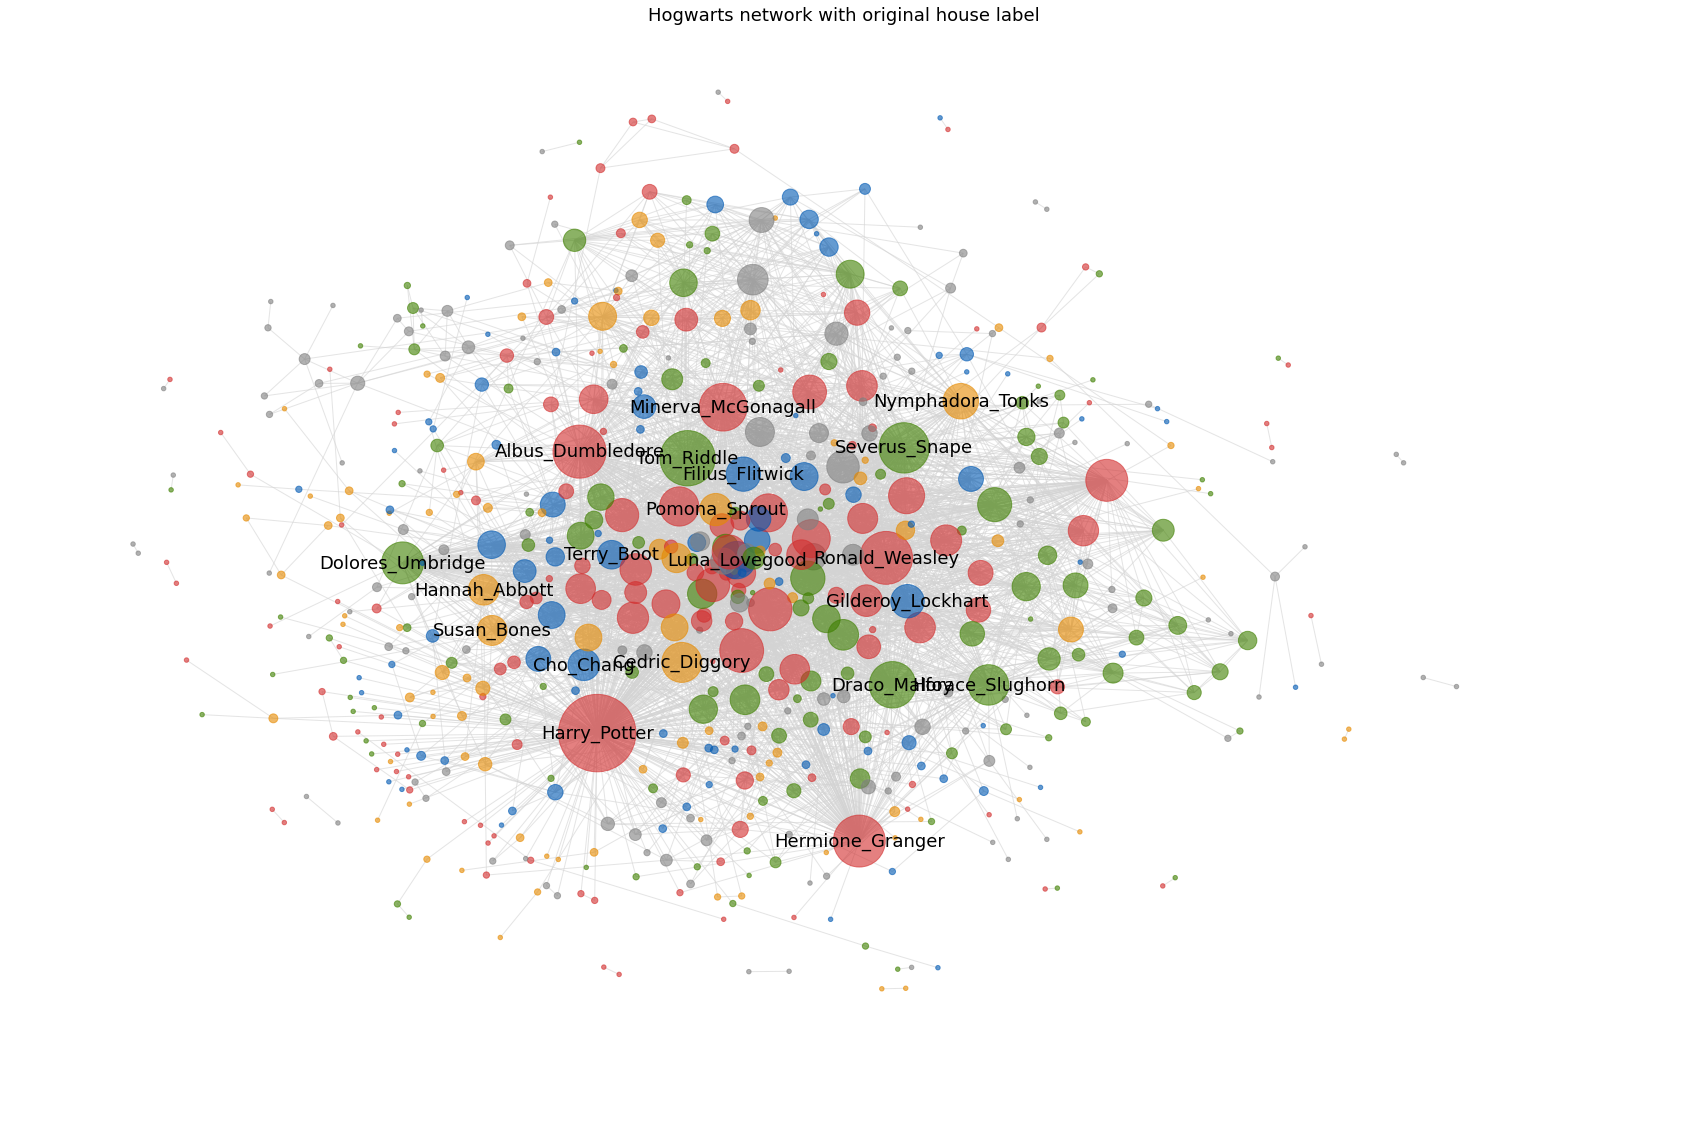

In [271]:
plt.figure(figsize=(30,20))
nx.draw_networkx(G_Hogwarts_unweighted, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_unweighted,positions,labels,font_size=18,font_color='k')
plt.title('Hogwarts network with original house label',fontdict = {'fontsize' : 18})
plt.axis('off')
plt.show()


Apply the louvain algorithm for both unweighted and weighted network and discuss the result. Louvain algorithm is a kind of community detection method based on modularity, below we give the detiled algorithm for it.

<font color=steelblue size = 4> **Introduction of Louvain algorithm:**</font>  
Louvain algorithm is a graph machine learning algorithm based on multi-level optimization Modularity, which performs well both in efficiency and effect. Its goal of optimization is to maximize the Modularity of the entire community network. In other words, find out the maximum value of modularity while in that time we can get the best community division by this algorithm.<br/>
Modularity is a measure to evaluate the division of a community network. Its physical meaning is that the number of edges of nodes within the community differs only from the number of edges under random circumstances. Its value range is \[−0.5,1), and be defined as follows: <br/>
$$\frac{1}{2m} \sum_{ij}[A_{ij}-\frac{k_i\times k_j}{2m}]\times \delta (C_i,C_j)$$<br/>
$A_{ij}$ is the weight of edge between node i and node j. When the network is not weighted graph, the weight of all edges can be regarded as 1.<br/>
$K_i = \sum_j A_{ij}$ for the sum of the weights of all the edges connected to node i. <br/>
$C_i$ represents the community that node i belongs<br/>
$m = \frac{1}{2} \sum_{ij} A_{ij}$ is the sum of the weights of all the sides<br/>
    
Steps of Louvain algorithm: <br/>
(1) At the beginning, each vertex is treated as a community, the number of communities is the same as the number of vertices, and the weight of connecting edges in the community is 0.<br/>
(2) Scan all nodes in the data, traverse all neighbor nodes for each node, and measure the modularity benefit of adding the node to the community where its neighbor node in. If the modular degree gain is greater than 0, select the neighbor node corresponding to the maximum benefit of modular degree gain and join its community. This process is repeated until the community ownership of each node does not change.<br/>
(3) All nodes in each community are compressed into a single node, and the weight of community interior points is converted into the weight of the new single node, and the weight of community is converted into the weight of new node edge.<br/>
(4) Repeat steps 2-3 until the communities are stable.<br/>

After get the partition from Louvain algorithm, variables about the partition are generated like *community* which contains the node in each community and use the community name as key. Then we color each node with its' new community, and visualize the network.

In [362]:

partition = community_louvain.best_partition(G_Hogwarts_unweighted)
par_class = set(partition.values())
par_class_dict = {}
for v in partition.values():
    str_v = str(v)
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1
par_sorted = sorted(par_class_dict.items(),key= lambda item:item[1],reverse = True)
# print(par_sorted[:10])
selected_par = list(dict(par_sorted).keys())[:5]
# print(selected_par)

community = {}
for par in selected_par:
    com_name = 'com_'+str(par)
    community[com_name] = []
community['other'] = []

for node in G_Hogwarts.nodes():
    if str(partition[node]) in selected_par:
        com_name = 'com_'+str(partition[node])
        community[com_name].append(node)
    else:
        community['other'].append(node)

In [368]:
# get the degree of node for each community
community_degree = {}
for node in G_Hogwarts.nodes():
    de = G_Hogwarts.degree(node)
    for c in community.keys():
        if node in community[c]:
            if c not in community_degree.keys():
                community_degree[c] = {}
            community_degree[c][node] = de
    
# get the top characters in each community
top_cha_unweighted = []
for com in community_degree:
    sorted_dict = sorted(community_degree[com].items(),key=lambda k:k[1],reverse=True)
    #degree_house[house] = sorted_dict
    print('The top 5 characters with the most degree in {}:'.format(com))
    print(sorted_dict[:8])
    for each in sorted_dict[:4]:
        top_cha_unweighted.append(each[0])

The top 5 characters with the most degree in other:
[('Minerva_McGonagall', 114), ('Horace_Slughorn', 82), ('Gilderoy_Lockhart', 56), ('Sybill_Trelawney', 39), ('Cadogan', 11), ('Ivy_Warrington', 8), ('Eloise_Midgen', 8), ('Gabriel_Truman', 7)]
The top 5 characters with the most degree in com_2:
[('Harry_Potter', 300), ('Salazar_Slytherin', 33), ('Rowena_Ravenclaw', 17), ('Unidentified_Gryffindor_girl_(1993-1994)_(I)', 15), ('Unidentified_Gryffindor_girl_(1993-1994)_(II)', 13), ('Unidentified_Hogwarts_students_at_the_Battle_of_Hogwarts', 13), ('Godric_Gryffindor', 12), ('Unidentified_Slytherin_girl_(I)', 11)]
The top 5 characters with the most degree in com_5:
[('Albus_Dumbledore', 141), ('Filius_Flitwick', 59), ('Pomona_Sprout', 52), ("Jacob's_sibling", 47), ('Nicholas_de_Mimsy-Porpington', 41), ('Penny_Haywood', 39), ('Merula_Snyde', 39), ('Barnaby_Lee', 38)]
The top 5 characters with the most degree in com_15:
[('Ronald_Weasley', 140), ('Hermione_Granger', 135), ('Ginevra_Weasley', 

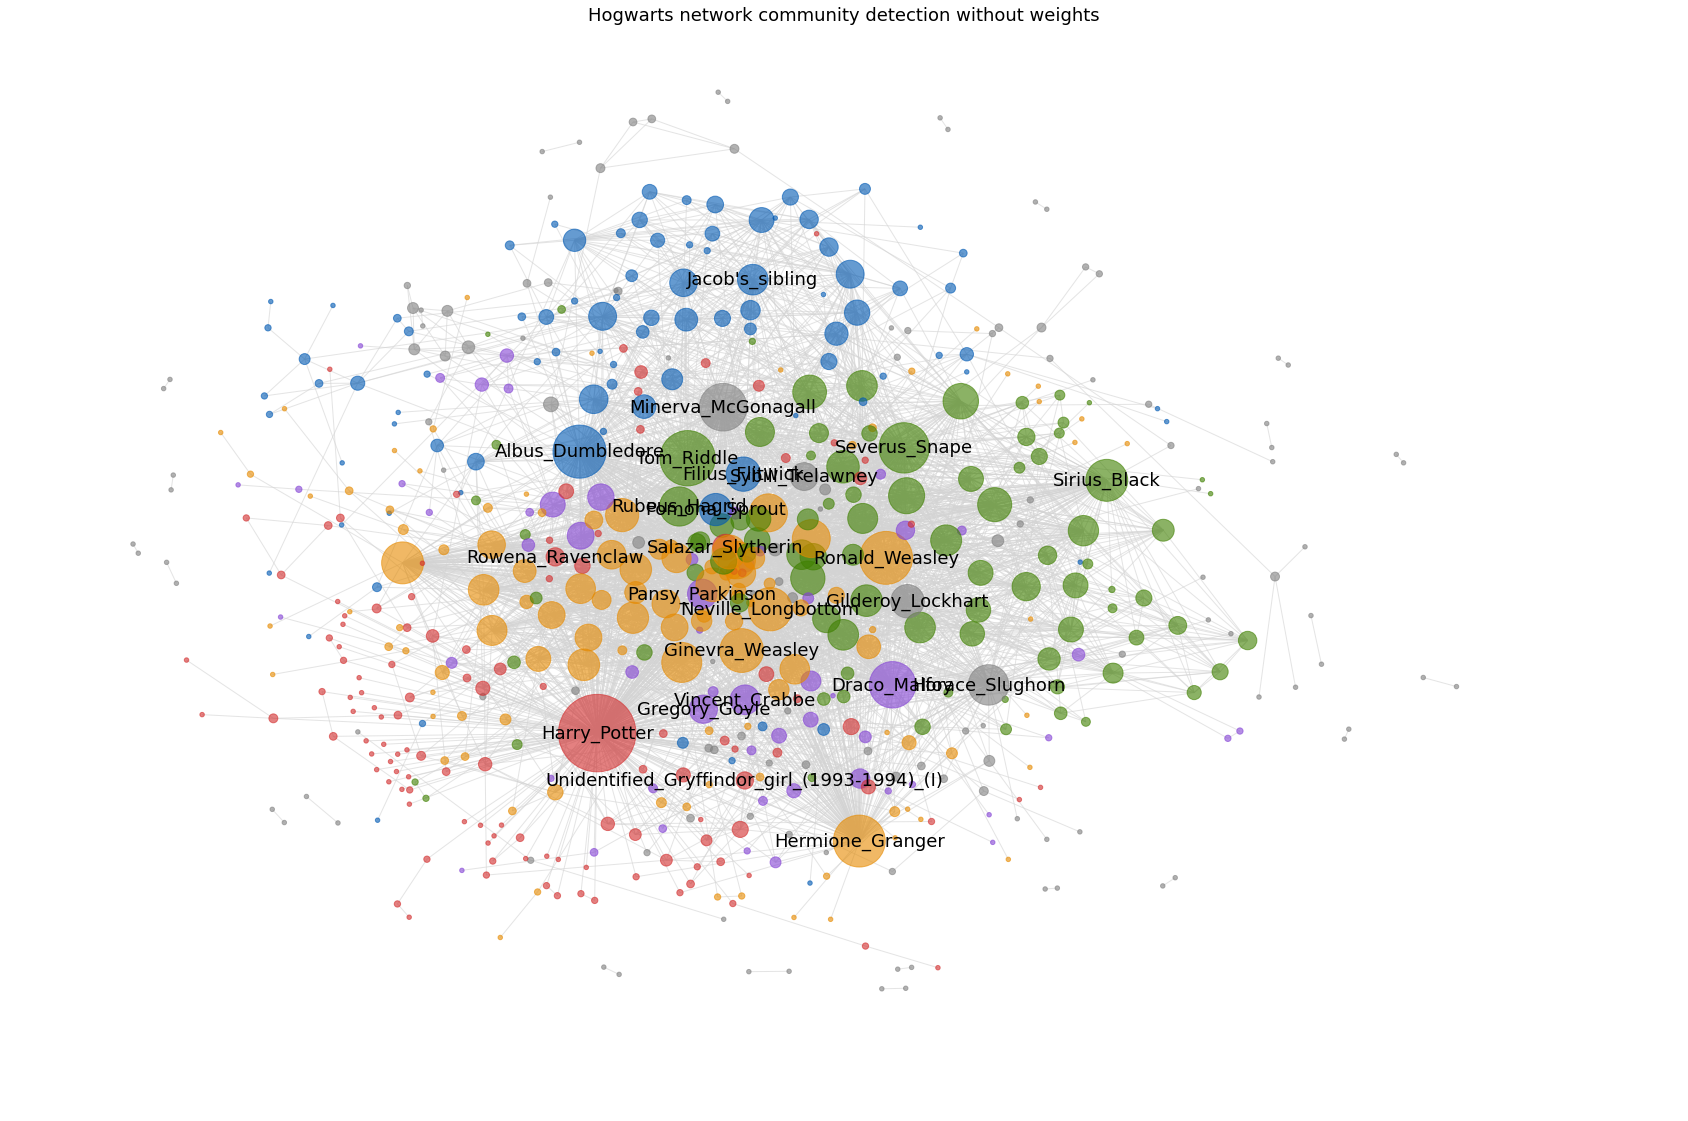

In [369]:
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#8443D5','#808080'] # 5 main community + other

# create a dict for each community
color_dict = {}
for i,par in enumerate(selected_par):
    color_dict[par] = colors[i]
color_dict['other'] = colors[-1]

# color map for nodes
color_map_nodes_2 = []
for node in list(G_Hogwarts_unweighted.nodes()):
    if str(partition[node]) in selected_par:
        color = color_dict[str(partition[node])]
    else:
        color = color_dict['other'] 
    color_map_nodes_2.append(color)

plt.figure(figsize=(30,20))
nx.draw_networkx(G_Hogwarts_unweighted, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes_2,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_cha_unweighted:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_unweighted,positions,labels,font_size=18,font_color='k')
plt.title('Hogwarts network community detection without weights',fontdict = {'fontsize' : 18})
plt.axis('off')
plt.show()

**The result** is very interesting here. Apparently, it differs a lot from the original house labels, and surprisingly, Harry Potter and Minerva McGonagall are separated from the other main characters. 
- The Yellow community here seems to be the Weasley family (Ginevra, Ron, Geoge, Fred) and their close friends (Hermione, Neville) or enemies (Dolores Umbridge). 
- And the Purple community seems to be some 'evil' guys in Harry Potter. Some of them are Draco Malfoy's friends(Vincent and Gregory), and some of them are dark wizards(Amycus and Alecto). 
- Characters in the Green community are more like some grown-ups, someone who has power. For example, Tom Riddle - the Voldemort; Lucius_Malfoy - Draco's father, works in the Ministry of Magic.
- The Blue community, the majority of the characters here are from Harry Potter's mobile game: *Harry Potter: Hogwarts Mystery*. 

**Then** we implement the Louvain algorithm again with weighted netword and see the result.

In [266]:
# louvain_partition = community.best_partition(G, weight='weight')
partition = community_louvain.best_partition(G_Hogwarts,weight='weight')
par_class = set(partition.values())
par_class_dict = {}
for v in partition.values():
    str_v = str(v)
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1
par_sorted = sorted(par_class_dict.items(),key= lambda item:item[1],reverse = True)
# print(par_sorted[:10])
selected_par = list(dict(par_sorted).keys())[:5]
# print(selected_par)

community = {}
for par in selected_par:
    com_name = 'com_'+str(par)
    community[com_name] = []
community['other'] = []

for node in G_Hogwarts.nodes():
    if str(partition[node]) in selected_par:
        com_name = 'com_'+str(partition[node])
        community[com_name].append(node)
    else:
        community['other'].append(node)

In [267]:
# get the degree of node for each community
community_degree = {}
for node in G_Hogwarts.nodes():
    de = G_Hogwarts.degree(node)
    for c in community.keys():
        if node in community[c]:
            if c not in community_degree.keys():
                community_degree[c] = {}
            community_degree[c][node] = de
    
# get the top characters in each community
top_cha_weighted = []
for com in community_degree:
    sorted_dict = sorted(community_degree[com].items(),key=lambda k:k[1],reverse=True)
    #degree_house[house] = sorted_dict
    print('The top 5 characters with the most degree in {}:'.format(com))
    print(sorted_dict[:5])
    for each in sorted_dict[:5]:
        top_cha_weighted.append(each[0])

The top 5 characters with the most degree in other:
[('Horace_Slughorn', 82), ('Nicholas_de_Mimsy-Porpington', 41), ('Salazar_Slytherin', 33), ('Unidentified_Ravenclaw_prefect', 31), ('Myrtle_Warren', 30)]
The top 5 characters with the most degree in com_2:
[('Harry_Potter', 300), ('Ronald_Weasley', 140), ('Hermione_Granger', 135), ('Ginevra_Weasley', 96), ('Neville_Longbottom', 94)]
The top 5 characters with the most degree in com_16:
[('Filius_Flitwick', 59), ("Jacob's_sibling", 47), ('Penny_Haywood', 39), ('Merula_Snyde', 39), ('Barnaby_Lee', 38)]
The top 5 characters with the most degree in com_21:
[('Draco_Malfoy', 108), ('Albus_Potter', 47), ('Vincent_Crabbe', 44), ('Pansy_Parkinson', 43), ('Gregory_Goyle', 40)]
The top 5 characters with the most degree in com_23:
[('Tom_Riddle', 153), ('Albus_Dumbledore', 141), ('Severus_Snape', 127), ('Sirius_Black', 88), ('Rubeus_Hagrid', 77)]
The top 5 characters with the most degree in com_35:
[('Minerva_McGonagall', 114), ('Grim_Fawley', 17

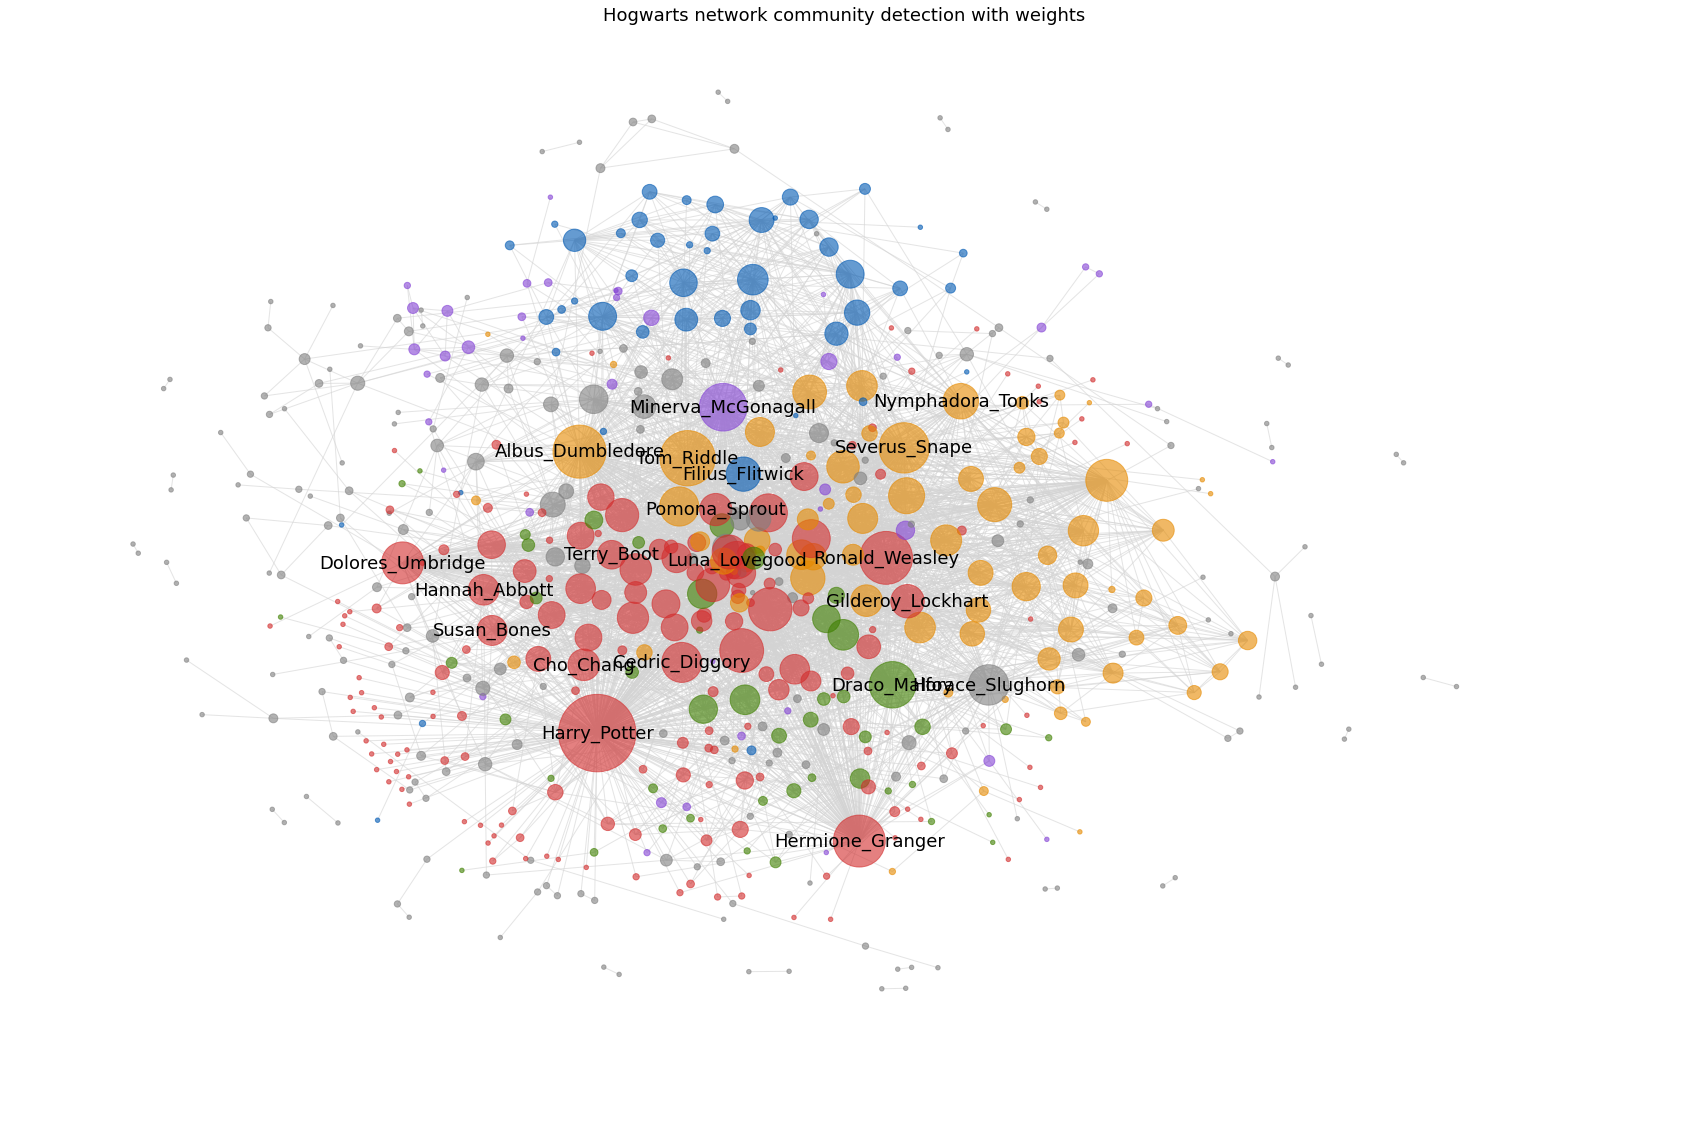

In [268]:
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#8443D5','#808080'] # 5 main community + other

# create a dict for each community
color_dict = {}
for i,par in enumerate(selected_par):
    color_dict[par] = colors[i]
color_dict['other'] = colors[-1]

# color map for nodes
color_map_nodes_2 = []
for node in list(G_Hogwarts.nodes()):
    if str(partition[node]) in selected_par:
        color = color_dict[str(partition[node])]
    else:
        color = color_dict['other'] 
    color_map_nodes_2.append(color)

plt.figure(figsize=(30,20))
nx.draw_networkx(G_Hogwarts, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes_2,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts,positions,labels,font_size=18,font_color='k')
plt.title('Hogwarts network community detection with weights',fontdict = {'fontsize' : 18})
plt.axis('off')
plt.show()

**Our observation and discussion here:**  
Firstly, we could see that the differences between the weighted and unweighted network are slight in the visualization. The main structure is similar, as we could see the color area is similar to each other. 

However, we could see:
1. For some key nodes, the result from community detection is really different, e.g. Harry Potter and Albus Dumbledore. We could see without the weights, Harry does not belong to the community which has his friends, but now he is! 
2. Also, we could see Dumbledore is separated from the mobile game's characters and 'return' to the grown-ups group.
3. The Purple community here seems to be related to *Fantastic Beasts and Where to Find Them*. Apart from professor Minerva McGonagall, other people seem to have appeared in that movie.

## 3.5 Prediction your house with description test

As a fan of Harry Potter, we are always curious which house are we belong to if we got a chance to enroll hogwarts. Enter a text description of yourself, which house will you be assigned to? We aim at combining the knowledge we have learned on network science with machine learning, so that fans ofHarry Potter can experience which house they are more similar to!

In this section, we are going to bulid a prediction model which gives the house prediction result of an input text. 

In [76]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random

**Step 1:** Read in the text file of Hogwarts characters and transform the predictors for later training. Here we use *TfidfVectorizer* in sklearn to generate the encoder based on TF-IDF results. Then, by transforming the raw text data with this encoder, we get the sparse matrix for each text. This sparse matrix is used as predictor in later work.

In [83]:
with open('./data/hogwarts_house.json','r') as f:
    x=json.load(f)
# print(x.keys())
collage_name=list(x.keys())

# read in the text
cnt=0
label=[]
data=[]
for type_name in list(x.keys())[:-1]:
    # print(type_name)
    for person_name in x[type_name]:
        #person_name=person_name.split(' ')
        #print(person_name)
        person_name=person_name.replace(' ','_')
        try:
            with open('./data/cha_fandom_page_text/'+person_name+'.txt','r',encoding='utf-8') as f:
                data_now=f.read()
            data.append(data_now)
            label.append(cnt)
        except:
#             print('error! path: ./cha_fandom_page_text/'+person_name+'.txt')
            pass
    cnt=cnt+1

# shuffle
r=random.random
random.seed(2)
random.shuffle(data,random=r)
random.seed(2)
random.shuffle(label,random=r)

# calculate the tf-idf
tf_transfomer = TfidfVectorizer(stop_words='english',decode_error='ignore')
X_train_counts_tf = tf_transfomer.fit_transform(data)

# print(tf_transfomer.get_feature_names()) # 

**Step 2:** Bulid the model and train the model. We take 700 data sample as training set and 181 samples as test set. The model we use is the logistic regression. 

In [78]:
# bulid and train model
model=LogisticRegression()
LR_result = model.fit(X=X_train_counts_tf[:700], y=label[:700])
pre=model.predict(X_train_counts_tf[700:])

correct=0
for i in range(700,811):
    if(pre[i-700]==label[i]):
        correct+=1
print('The correctness rate:{}'.format(correct*1.0/len(pre)))

# store the model parameters
import joblib
joblib.dump(LR_result,'LR.model')
joblib.dump(tf_transfomer,'TF_IDF.model')

The correctness rate:0.963963963963964


['TF_IDF.model']

We could see that the correctness rate is around 96.39%, which is quite high, indicating that our prediction model has strong ability in this classfication task.

**Step 3:** Prediction!  
By inputing a text of description of somebody, we could then get which house is this text most similar to.
Here we choose a paragraph which describe Alan Turing, who was an English mathematician, computer scientist, logician, cryptanalyst, philosopher, and theoretical biologist. 

In [102]:
file_path = './data/Alan_Turing.txt'
with open(file_path,'r',encoding='utf-8') as f:
    text = f.read()

In [105]:
# read in the model and predict
rf_model=joblib.load('TF_IDF.model')
LR_model=joblib.load('LR.model')

pre=LR_model.predict(rf_model.transform([text]))
print(collage_name[pre[0]])

Slytherins


We could see that Alan Turing is assigned to Slytherins. This result matches our expectation as Alan Turing is extremly smart and has  outstanding talents. Apart from the brillance, his personality is weird and sometimes he acted strangely. Syltherions are considered to be ambitious, shrewd and honorable, which matches Alan Turing's traits. 

You could also use the following API to get your own result! 

In [111]:
predictAPIlink = 'http://121.4.37.184:8888/pre?'
txt = 'txt={}'.format(text)
import requests
query = '{}{}'.format(predictAPIlink,txt)
r = requests.get(query)
res= r.text
print((res.split(',')[1]).split(':')[1][2:-2])

Slytherins


# 4. Discussion
<!--
* What went well?,
* What is still missing? What could be improved?, Why?
-->

## 4.1 Summary on our result

其实我不知道这边还能讲啥。一般discussion可能会说一些延伸的东西。



## 4.2 Problems and possible improvement

潜在的问题以及可能的解决办法。未来的方向。

#### Summary on our results
To explore the World of Harry Potter, we crawled character nodes and related information from fandom website. Totally we got ('?').
Nodes links to other characters in the corresponding character page of each node are taken as the link between nodes in the network. The introduction in the page of each character is stored locally as the text mining material. Based on this, we construct the character social network in the Harry Potter world and use the social Graphs analysis method we learned to carry out a series of analyses.(details)
In addition, the original harry Potter novels are also very important material, which contains most of the information of the World of Harry Potter, but here we only focus on exploring the characters of the world of Harry Potter. 
It's not very precise, but it does say something about a particular person's disposition. First, the text is divided into sentences, and then the sentences with the names of the characters are grouped into TXT file named by the character name, so that the sentences that the character appears in the book forms a text set of that character. Then, through sentiment analysis for the text, we get the
positive values of the characters as a benchmark for judging their emotional preferences, and further exploring the difference in personality of the four Colleges, then judging whether the results of the analysis are reliable.
After that, we conducted community detection and analysis based on the semantic similarity between characters. Furthermore, a classifier based on machine learning algorithm is constructed to simulate the working mechanism of sorting hat to classify new characters.
Come on! Enter your own description so you know which college you'll be cast in if you go into Hogwarts!<br/>

Here's what we've learned from our analysis:<br/>
(1) <br/>
(2) <br/>